In [ ]:
import numpy as np
import pandas as pd
fname = ""
df= pd.read_csv(fname)

In [5]:
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, f1_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import export_text, plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score,roc_auc_score
from scipy.stats import boxcox

In [6]:
y_cols=['irmjfy', 'ircocfy', 'ircrkfy', 'irhallucyfq', 'irinhalyfq', 'irmethamyfq', 'IRSEDNM30FQ', 'IRSTMNM30FQ', 'IRTRQNM30FQ', 'irmjfm', 'ircocfm', 'ircrkfm', 'irherfy', 'IRHALLUC30N', 'IRINHAL30N', 'IRMETHAM30N', 'IRPNRNM30FQ']

In [7]:
df_final=df[X_cols+y_cols]

In [8]:
for col in df_final.columns:
    nulls=df[col].isnull().sum()
    if nulls>5000:
        df.drop([col],axis=1,inplace=True)

In [9]:
df_final.dropna(axis=0,inplace=True)

C:\Users\pc\AppData\Local\Temp\ipykernel_3916\3673506568.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.dropna(axis=0,inplace=True)


In [10]:
df=df_final

--------------------------- 여기까지는 필수로 돌려야함 ---------------------------

In [51]:
y_cols=['irmjfy', 'ircocfy', 'ircrkfy', 'irhallucyfq', 'irinhalyfq', 'irmethamyfq', 'IRSEDNM30FQ', 'IRSTMNM30FQ', 'IRTRQNM30FQ', 'irmjfm', 'ircocfm', 'ircrkfm', 'irherfy', 'IRHALLUC30N', 'IRINHAL30N', 'IRMETHAM30N', 'IRPNRNM30FQ']

## x: 약물, 일부 컬럼 제외 / y: 366 이상 제외

In [38]:
X_cols=['COUTYP4',
 'AIIND102',
 'CATAG6',
 'NEWRACE2',
 'HEALTH2',
 'ENRLCOLLST2',
 'IRWRKSTAT18',
 'NRCH17_2',
 'IRHHSIZ2',
 'IRKI17_2',
 'IRHH65_2',
 'POVERTY3',
 'eduhighcat',
 'irwrkstat',
 'govtprog',
 'income']

 --      RF      -- 
r2 : -3.6084796255131586  mse:  14766.018994117647  mae:  102.25823529411765


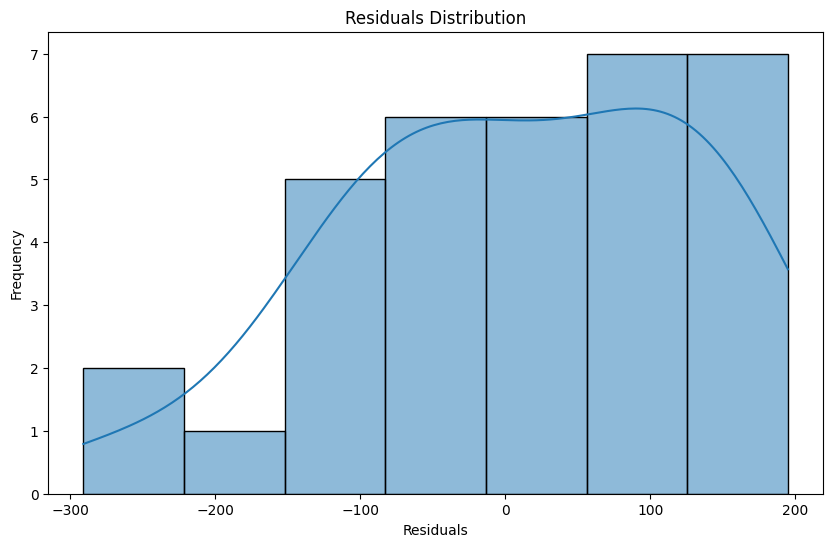

Quantile Analysis:
(198.0, 260.0]: {'r2': -133.59042275000002, 'mse': 6592.183971428572, 'mae': 67.11428571428573}
(0.999, 2.9]: {'r2': -119254.7692, 'mse': 22360.456725, 'mae': 138.21249999999998}
(264.0, 331.2]: {'r2': -560.4134302083334, 'mse': 17965.229766666667, 'mae': 126.65000000000002}
(96.0, 107.6]: {'r2': -667.3551583333334, 'mse': 2005.065475, 'mae': 35.1125}
(2.9, 35.6]: {'r2': -5201.768300000001, 'mse': 41622.146400000005, 'mae': 190.49333333333334}
(331.2, 362.8]: {'r2': 0.0, 'mse': 20634.4818, 'mae': 139.31333333333333}
(362.8, 364.0]: {'r2': 0.0, 'mse': 22802.608500000002, 'mae': 144.675}
(35.6, 96.0]: {'r2': -509.33143203124996, 'mse': 7258.047033333333, 'mae': 84.50333333333333}
(107.6, 198.0]: {'r2': -5.211661159169549, 'mse': 1595.7067333333332, 'mae': 37.36666666666667}


In [39]:
a=df[df['irherfy']<366]
a_x = a[X_cols]
a_y = a['irherfy']
def train_with_each_y(Xdata,Ydata):
    X_train, X_test,y_train,y_test=train_test_split(Xdata,Ydata)
    # Random Forest Regressor
    rt_reg=RandomForestRegressor()
    rt_reg.fit(X_train, y_train)
    pred_y = rt_reg.predict(X_test)
    print(' --      RF      -- ', end='\n')
    print('r2 :', r2_score(pred_y, y_test), ' mse: ', mean_squared_error(pred_y, y_test), ' mae: ', mean_absolute_error(pred_y, y_test))
    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
    
    # 분위수 분석
    quantiles = np.linspace(0, 1, 11)
    y_quantiles = np.quantile(y_test, quantiles)
    quantile_groups = pd.cut(y_test, y_quantiles, include_lowest=True)
    
    quantile_metrics = {}
    for q in quantile_groups.unique():
        mask = quantile_groups == q
        q_r2 = r2_score(y_test[mask], pred_y[mask])
        q_mse = mean_squared_error(y_test[mask], pred_y[mask])
        q_mae = mean_absolute_error(y_test[mask], pred_y[mask])
        quantile_metrics[str(q)] = {'r2': q_r2, 'mse': q_mse, 'mae': q_mae}
    
    print('Quantile Analysis:')
    for quantile, metrics in quantile_metrics.items():
        print(f"{quantile}: {metrics}")


train_with_each_y(a_x,a_y)

## x: 원핫인코딩 / y: 366 이상 0으로 바꿈

In [9]:
cols_to_drop = ['PDEN10', 'CATAG2', 'CATAG3', 'CATAG7', 'PREGAGE2', 'ENRLCOLLFT2', 
                'II2WRKSTAT', 'IIWRKSTAT18', 'II2WRKST18', 'EDFAM18', 'IIHHSIZ2', 
                'IIKI17_2', 'IIHH65_2', 'catage', 'drvinage', 'drvindetag', 
                'sexage', 'iiwrkstat', 'imother', 'ifather', 'snysell', 
                'snystole', 'snyattak', 'snfamjev', 'snrlgsvc', 'snrlgimp', 
                'snrldcsn', 'snrlfrnd']

# cols_to_drop에 존재하지 않는 열을 필터링
cols_to_drop_filtered = [col for col in cols_to_drop if col in df.columns]

# df2에 결과 할당 (inplace=True 사용 안 함)
df2 = df.drop(cols_to_drop_filtered, axis=1)

# 원핫인코딩할 열의 리스트 (실제 X_cols 리스트로 교체)
X_cols = ['COUTYP4', 'AIIND102', 'CATAG6', 'NEWRACE2', 'HEALTH2', 'ENRLCOLLST2', 
          'IRWRKSTAT18', 'NRCH17_2', 'IRHHSIZ2', 'IRKI17_2', 'IRHH65_2', 
          'POVERTY3', 'eduhighcat', 'irwrkstat', 'govtprog', 'income']

# df2와 X_cols가 None이 아닌지 확인
if df2 is None:
    raise ValueError("df2가 None입니다.")
if X_cols is None:
    raise ValueError("X_cols가 None입니다.")

# X_cols의 모든 열이 df2에 존재하는지 확인
missing_cols = [col for col in X_cols if col not in df2.columns]
if missing_cols:
    raise ValueError(f"df2에 존재하지 않는 열이 있습니다: {missing_cols}")

# 원핫인코딩 수행
df2_encoded = pd.get_dummies(df2, columns=X_cols, prefix=X_cols)

print(df2_encoded)

       irmjfy  ircocfy  ircrkfy  irhallucyfq  irinhalyfq  irmethamyfq  \
0         991      991      991          991         991          991   
1         364      991      991          993         993          991   
2         991      991      991          991         991          991   
3         991      991      991          991         991          991   
4         108      991      991          991         993          991   
...       ...      ...      ...          ...         ...          ...   
42806     991      991      991          991         991          991   
42807       1      991      991          991         991          991   
42808     364      991      991          991         991          991   
42809      44      991      991          991         991          991   
42810     208      991      991          991         991          991   

       IRSEDNM30FQ  IRSTMNM30FQ  IRTRQNM30FQ  irmjfm  ...  irwrkstat_2  \
0             91.0         91.0         91.0    9

## x: 원핫인코딩 / y: 366 이상 제외

 --      RF      -- 
r2 : 0.8996858484311564  mse:  7.099933611111111  mae:  2.204388888888889
row 수: 357


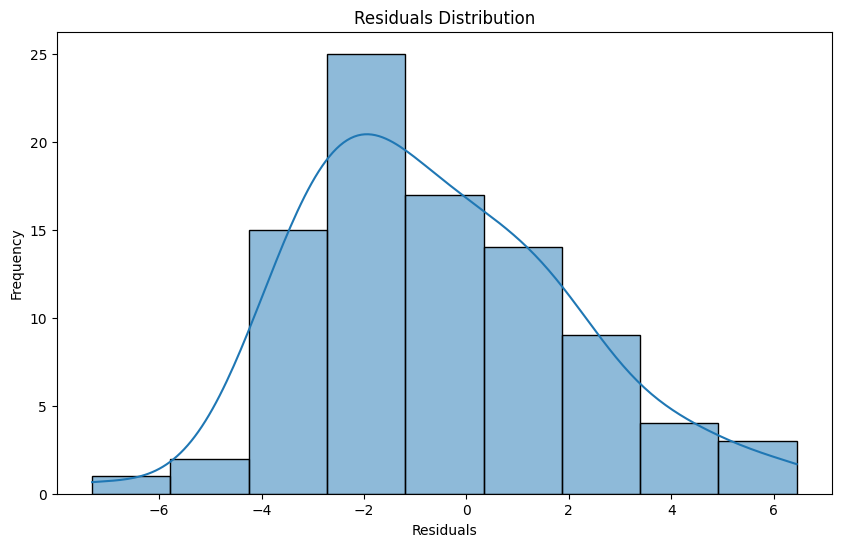

Quantile Analysis:
(0.999, 2.0]: {'r2': -25.59403214285715, 'mse': 6.153990909090909, 'mae': 2.2345454545454544}
(3.0, 4.0]: {'r2': 0.0, 'mse': 1.5024625000000003, 'mae': 0.9434999999999999}
(2.0, 3.0]: {'r2': 0.0, 'mse': 4.056141666666666, 'mae': 1.5250000000000001}
(10.4, 21.4]: {'r2': -0.11534081632653059, 'mse': 12.144822222222222, 'mae': 2.711111111111111}
(4.0, 7.0]: {'r2': -7.256926966292134, 'mse': 7.348665, 'mae': 2.5}
(7.0, 10.4]: {'r2': -38.5041328125, 'mse': 25.282645, 'mae': 4.7989999999999995}
(21.4, 30.0]: {'r2': -0.4319945000000003, 'mse': 3.535788888888889, 'mae': 1.4077777777777776}


In [50]:
a=df2_encoded[df2_encoded['IRPNRNM30FQ']<32]
a_x = a.drop(columns=y_cols)
a_y = a['IRPNRNM30FQ']
def train_with_each_y(Xdata,Ydata):
    X_train, X_test,y_train,y_test=train_test_split(Xdata,Ydata)
    # Random Forest Regressor
    rt_reg=RandomForestRegressor()
    rt_reg.fit(X_train, y_train)
    pred_y = rt_reg.predict(X_test)
    print(' --      RF      -- ', end='\n')
    print('r2 :', r2_score(pred_y, y_test), ' mse: ', mean_squared_error(pred_y, y_test), ' mae: ', mean_absolute_error(pred_y, y_test))
    print('row 수:', a_x.shape[0])
    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
    
    # 분위수 분석
    quantiles = np.linspace(0, 1, 11)
    y_quantiles = np.quantile(y_test, quantiles)
    quantile_groups = pd.cut(y_test, y_quantiles, include_lowest=True, duplicates='drop') #오류 발생시 duplicates='drop'
    
    quantile_metrics = {}
    for q in quantile_groups.unique():
        mask = quantile_groups == q
        q_r2 = r2_score(y_test[mask], pred_y[mask])
        q_mse = mean_squared_error(y_test[mask], pred_y[mask])
        q_mae = mean_absolute_error(y_test[mask], pred_y[mask])
        quantile_metrics[str(q)] = {'r2': q_r2, 'mse': q_mse, 'mae': q_mae}
    
    print('Quantile Analysis:')
    for quantile, metrics in quantile_metrics.items():
        print(f"{quantile}: {metrics}")


train_with_each_y(a_x,a_y)

In [47]:
yy_cols = ['irmjfy',
'ircocfy',
'ircrkfy',
'irherfy',
'irhallucyfq',
'irinhalyfq',
'irmethamyfq']

ym_cols = ['irmjfm',
'ircocfm',
'ircrkfm',
'IRHALLUC30N',
'IRINHAL30N',
'IRMETHAM30N',
'IRPNRNM30FQ']

## x: 약물 제외 y: 366 이상 제외

In [9]:
X_cols2 = X_cols.copy()
cols_to_drop = ['PDEN10', 'AIIND102', 'CATAG2', 'CATAG3', 'CATAG7', 'HEALTH2', 'PREGAGE2', 'ENRLCOLLFT2', 
                'II2WRKSTAT', 'IIWRKSTAT18', 'II2WRKST18', 'EDFAM18', 'IIHHSIZ2', 
                'IIKI17_2', 'IIHH65_2', 'catage', 'drvinage', 'drvindetag', 
                'sexage', 'iiwrkstat', 'imother', 'ifather', 'snysell', 
                'snystole', 'snyattak', 'snfamjev', 'snrlgsvc', 'snrlgimp', 
                'snrldcsn', 'snrlfrnd', 'POVERTY3','IRWRKSTAT18']
for i in cols_to_drop:
    X_cols2.remove(i)
print(X_cols2)

['COUTYP4', 'CATAG6', 'NEWRACE2', 'ENRLCOLLST2', 'NRCH17_2', 'IRHHSIZ2', 'IRKI17_2', 'IRHH65_2', 'eduhighcat', 'irwrkstat', 'govtprog', 'income']


## 구글문서 첨부1

 --      RF      -- 
r2 : -2.9589326472338553  mse:  149777.4001208643  mae:  287.1990496473758


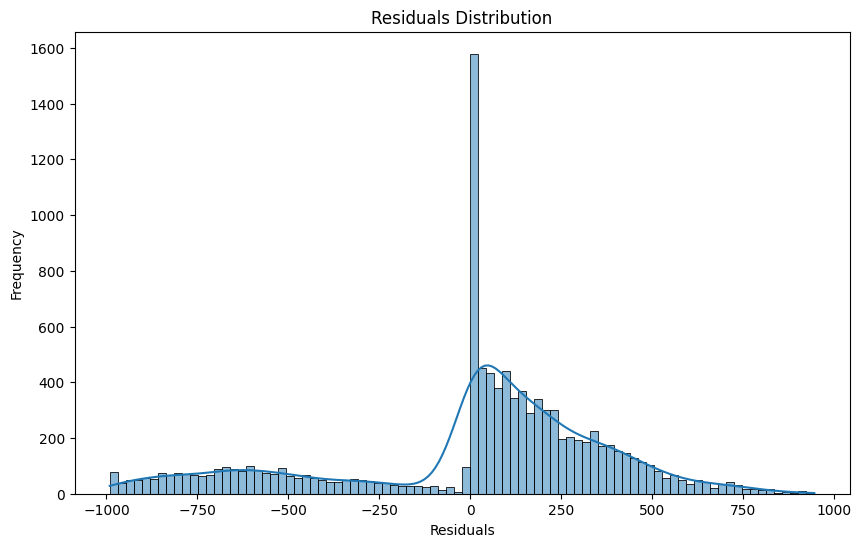

Quantile Analysis:
(360.0, 991.0]: {'r2': -2.060834534262063, 'mse': 74530.42293914063, 'mae': 195.72448288270607}
(991.0, 993.0]: {'r2': 0.0, 'mse': 87166.225600122, 'mae': 228.13595237990899}
(48.0, 360.0]: {'r2': -31.310417320137418, 'mse': 312759.4492892942, 'mae': 511.3449440236196}
(0.999, 48.0]: {'r2': -3210.690613356411, 'mse': 547244.322246272, 'mae': 713.0940648859573}


In [21]:
a=df
a_x = a[X_cols2]
a_y = a['irmjfy']
def train_with_each_y(Xdata,Ydata):
    X_train, X_test,y_train,y_test=train_test_split(Xdata,Ydata)
    # Random Forest Regressor
    rt_reg=RandomForestRegressor()
    rt_reg.fit(X_train, y_train)
    pred_y = rt_reg.predict(X_test)
    print(' --      RF      -- ', end='\n')
    print('r2 :', r2_score(pred_y, y_test), ' mse: ', mean_squared_error(pred_y, y_test), ' mae: ', mean_absolute_error(pred_y, y_test))
    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
    
    # 분위수 분석
    quantiles = np.linspace(0, 1, 11)
    y_quantiles = np.quantile(y_test, quantiles)
    quantile_groups = pd.cut(y_test, y_quantiles, include_lowest=True, duplicates='drop')
    
    quantile_metrics = {}
    for q in quantile_groups.unique():
        mask = quantile_groups == q
        q_r2 = r2_score(y_test[mask], pred_y[mask])
        q_mse = mean_squared_error(y_test[mask], pred_y[mask])
        q_mae = mean_absolute_error(y_test[mask], pred_y[mask])
        quantile_metrics[str(q)] = {'r2': q_r2, 'mse': q_mse, 'mae': q_mae}
    
    print('Quantile Analysis:')
    for quantile, metrics in quantile_metrics.items():
        print(f"{quantile}: {metrics}")


train_with_each_y(a_x,a_y)

In [ ]:
a=df[df['irmjfy']<366]
a_x = a[X_cols2]
a_y = a['irmjfy']
def train_with_each_y(Xdata,Ydata):
    X_train, X_test,y_train,y_test=train_test_split(Xdata,Ydata)
    # Random Forest Regressor
    rt_reg=RandomForestRegressor()
    rt_reg.fit(X_train, y_train)
    pred_y = rt_reg.predict(X_test)
    print(' --      RF      -- ', end='\n')
    print('r2 :', r2_score(pred_y, y_test), ' mse: ', mean_squared_error(pred_y, y_test), ' mae: ', mean_absolute_error(pred_y, y_test))
    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
    
    # 분위수 분석
    quantiles = np.linspace(0, 1, 11)
    y_quantiles = np.quantile(y_test, quantiles)
    quantile_groups = pd.cut(y_test, y_quantiles, include_lowest=True)
    
    quantile_metrics = {}
    for q in quantile_groups.unique():
        mask = quantile_groups == q
        q_r2 = r2_score(y_test[mask], pred_y[mask])
        q_mse = mean_squared_error(y_test[mask], pred_y[mask])
        q_mae = mean_absolute_error(y_test[mask], pred_y[mask])
        quantile_metrics[str(q)] = {'r2': q_r2, 'mse': q_mse, 'mae': q_mae}
    
    print('Quantile Analysis:')
    for quantile, metrics in quantile_metrics.items():
        print(f"{quantile}: {metrics}")


train_with_each_y(a_x,a_y)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
 --      RF      -- 
r2 : -9.634683215287698  mse:  17965.529277598092  mae:  118.47196102218409


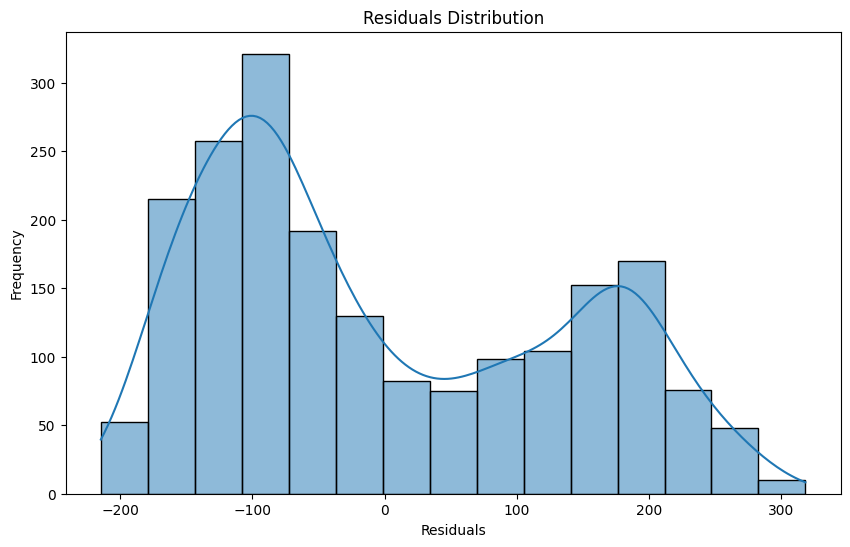

Quantile Analysis:
(0.999, 2.0]: {'r2': -68798.818770396, 'mse': 17012.20735913111, 'mae': 125.26987518875491}
(15.0, 36.0]: {'r2': -343.14266101881407, 'mse': 12561.938939428153, 'mae': 103.8483830008772}
(6.0, 15.0]: {'r2': -3014.285742543416, 'mse': 15628.259705021084, 'mae': 118.80457564175673}
(312.0, 364.0]: {'r2': -773.9348058723568, 'mse': 42412.15092767297, 'mae': 202.60220171251257}
(156.0, 260.0]: {'r2': -8.11900712329567, 'mse': 9206.304832433252, 'mae': 85.02139415326404}
(60.0, 156.0]: {'r2': -2.1624123137642943, 'mse': 2799.218473307866, 'mae': 43.347887759095876}
(260.0, 312.0]: {'r2': -381.81584402463824, 'mse': 27524.93680060222, 'mae': 160.01755008387553}
(36.0, 60.0]: {'r2': -257.561716966994, 'mse': 8056.124934790474, 'mae': 79.41940040623845}
(2.0, 6.0]: {'r2': -14715.042889716884, 'mse': 16752.05233872928, 'mae': 121.9627047727872}
(364.0, 365.0]: {'r2': 0.0, 'mse': 41268.7779283879, 'mae': 200.3848005280692}


In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV #하이퍼파라미터튜닝
from sklearn.preprocessing import StandardScaler #표준화

# 데이터 전처리: 'irmjfy'가 366보다 작은 데이터 선택
a = df[df['irmjfy'] < 366]
a_x = a[X_cols2]
a_y = a['irmjfy']

# 데이터 표준화
scaler = StandardScaler()
a_x_scaled = scaler.fit_transform(a_x)

def train_with_each_y(Xdata, Ydata):
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
    
    # 하이퍼파라미터 그리드 설정
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    rt_reg = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rt_reg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    best_rt_reg = grid_search.best_estimator_
    pred_y = best_rt_reg.predict(X_test)

    print(' --      RF      -- ')
    print('r2 :', r2_score(pred_y, y_test), ' mse: ', mean_squared_error(pred_y, y_test), ' mae: ', mean_absolute_error(pred_y, y_test))
    
    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
    
    # 분위수 분석
    quantiles = np.linspace(0, 1, 11)
    y_quantiles = np.quantile(y_test, quantiles)
    quantile_groups = pd.cut(y_test, y_quantiles, include_lowest=True)
    
    quantile_metrics = {}
    for q in quantile_groups.unique():
        mask = quantile_groups == q
        q_r2 = r2_score(y_test[mask], pred_y[mask])
        q_mse = mean_squared_error(y_test[mask], pred_y[mask])
        q_mae = mean_absolute_error(y_test[mask], pred_y[mask])
        quantile_metrics[str(q)] = {'r2': q_r2, 'mse': q_mse, 'mae': q_mae}
    
    print('Quantile Analysis:')
    for quantile, metrics in quantile_metrics.items():
        print(f"{quantile}: {metrics}")

train_with_each_y(a_x_scaled, a_y)

Cross-validated R2 scores: [-0.03890687 -0.02679684 -0.0654558  -0.06635751 -0.02192712]
Mean R2 score: -0.043888827881521084
 --      RF      -- 
r2 : -3.6785310006756706  mse:  20416.14546856987  mae:  121.47932780311325


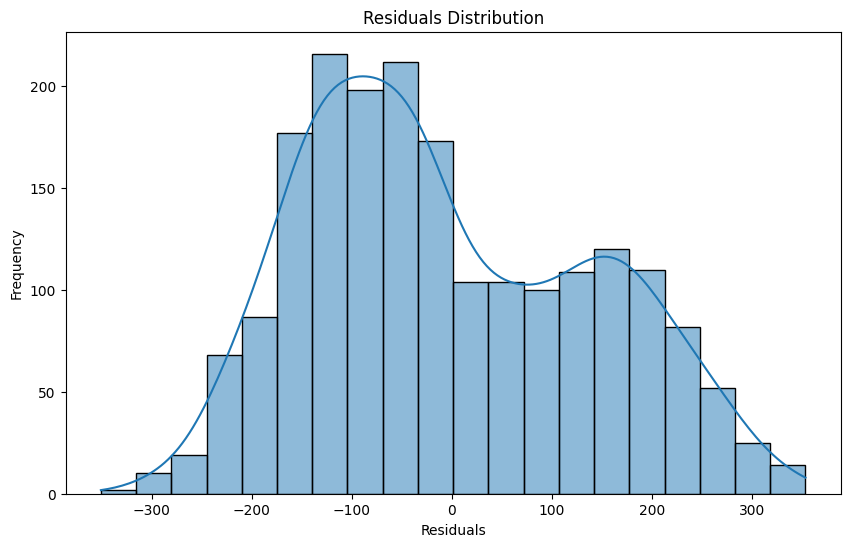

Quantile Analysis:
(0.999, 2.0]: {'r2': -84172.34571209451, 'mse': 20813.636386817754, 'mae': 128.7173019693196}
(15.0, 36.0]: {'r2': -420.7977531593317, 'mse': 15396.514934502244, 'mae': 106.25912860754148}
(6.0, 15.0]: {'r2': -3831.5017677045716, 'mse': 19863.899497338276, 'mae': 126.30174087252728}
(312.0, 364.0]: {'r2': -790.929319004303, 'mse': 43342.25995159664, 'mae': 197.98980342109544}
(156.0, 260.0]: {'r2': -9.183968226869366, 'mse': 10281.460978450232, 'mae': 84.63909248271301}
(60.0, 156.0]: {'r2': -4.687966533672247, 'mse': 5034.720149334384, 'mae': 56.68183519168501}
(260.0, 312.0]: {'r2': -403.51590877130457, 'mse': 29085.19852969232, 'mae': 155.48803149549818}
(36.0, 60.0]: {'r2': -363.52054518344687, 'mse': 11357.53230502662, 'mae': 87.42076333811247}
(2.0, 6.0]: {'r2': -18710.170435156197, 'mse': 21299.917973713575, 'mae': 129.30512394131912}
(364.0, 365.0]: {'r2': 0.0, 'mse': 37658.90535513407, 'mae': 184.05544941392395}


In [15]:
from sklearn.model_selection import train_test_split, cross_val_score #교차검증

# 데이터 전처리: 'irmjfy'가 366보다 작은 데이터 선택
a = df[df['irmjfy'] < 366]
a_x = a[X_cols2]
a_y = a['irmjfy']

def train_with_each_y(Xdata, Ydata):
    # Random Forest Regressor
    rt_reg = RandomForestRegressor()

    # 교차 검증
    cv_scores = cross_val_score(rt_reg, Xdata, Ydata, cv=5, scoring='r2')
    print('Cross-validated R2 scores:', cv_scores)
    print('Mean R2 score:', np.mean(cv_scores))

    # 모델 훈련 및 평가
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
    rt_reg.fit(X_train, y_train)
    pred_y = rt_reg.predict(X_test)
    print(' --      RF      -- ')
    print('r2 :', r2_score(pred_y, y_test), ' mse: ', mean_squared_error(pred_y, y_test), ' mae: ', mean_absolute_error(pred_y, y_test))

    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # 분위수 분석
    quantiles = np.linspace(0, 1, 11)
    y_quantiles = np.quantile(y_test, quantiles)
    quantile_groups = pd.cut(y_test, y_quantiles, include_lowest=True)

    quantile_metrics = {}
    for q in quantile_groups.unique():
        mask = quantile_groups == q
        q_r2 = r2_score(y_test[mask], pred_y[mask])
        q_mse = mean_squared_error(y_test[mask], pred_y[mask])
        q_mae = mean_absolute_error(y_test[mask], pred_y[mask])
        quantile_metrics[str(q)] = {'r2': q_r2, 'mse': q_mse, 'mae': q_mae}

    print('Quantile Analysis:')
    for quantile, metrics in quantile_metrics.items():
        print(f"{quantile}: {metrics}")

train_with_each_y(a_x, a_y)

 --      RF      -- 
r2 : -3.0898972287426894  mse:  143976.52651926596  mae:  283.39078884202615


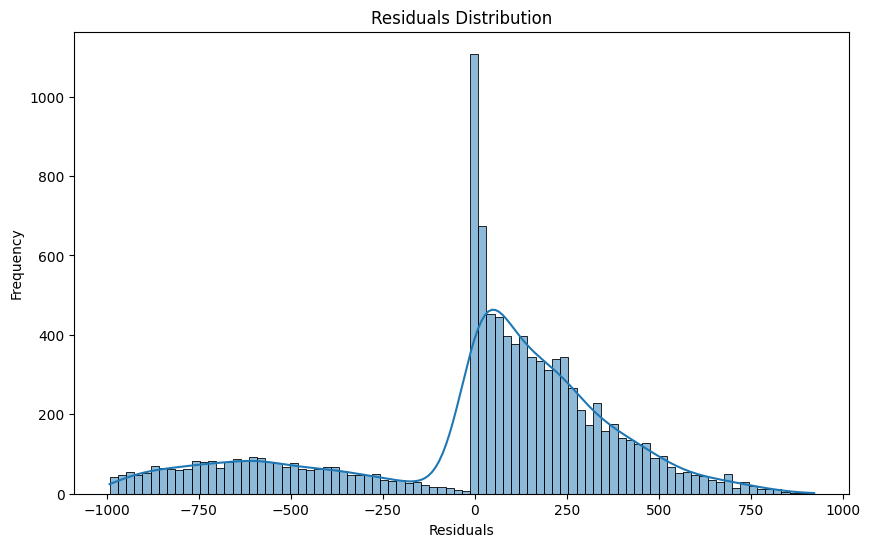

Quantile Analysis:
(360.0, 991.0]: {'r2': -2.1743891972421614, 'mse': 69237.0622954689, 'mae': 191.5496811959912}
(991.0, 993.0]: {'r2': 0.0, 'mse': 83874.46544502772, 'mae': 225.71174572960157}
(0.999, 36.0]: {'r2': -4545.420306414023, 'mse': 528220.3264793362, 'mae': 701.0681280369624}
(36.0, 360.0]: {'r2': -30.212144698855287, 'mse': 319550.1599461896, 'mae': 521.0404592342223}


In [18]:
#표준화만 진행
#a = df[df['irmjfy'] < 366]
a = df
a_x = a[X_cols2]
a_y = a['irmjfy']

scaler = StandardScaler()
a_x_scaled = scaler.fit_transform(a_x)
def train_with_each_y(Xdata,Ydata):
    X_train, X_test,y_train,y_test=train_test_split(Xdata,Ydata)
    # Random Forest Regressor
    rt_reg=RandomForestRegressor()
    rt_reg.fit(X_train, y_train)
    pred_y = rt_reg.predict(X_test)
    print(' --      RF      -- ', end='\n')
    print('r2 :', r2_score(pred_y, y_test), ' mse: ', mean_squared_error(pred_y, y_test), ' mae: ', mean_absolute_error(pred_y, y_test))
    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
    
    # 분위수 분석
    quantiles = np.linspace(0, 1, 11)
    y_quantiles = np.quantile(y_test, quantiles)
    quantile_groups = pd.cut(y_test, y_quantiles, include_lowest=True, duplicates='drop')
    
    quantile_metrics = {}
    for q in quantile_groups.unique():
        mask = quantile_groups == q
        q_r2 = r2_score(y_test[mask], pred_y[mask])
        q_mse = mean_squared_error(y_test[mask], pred_y[mask])
        q_mae = mean_absolute_error(y_test[mask], pred_y[mask])
        quantile_metrics[str(q)] = {'r2': q_r2, 'mse': q_mse, 'mae': q_mae}
    
    print('Quantile Analysis:')
    for quantile, metrics in quantile_metrics.items():
        print(f"{quantile}: {metrics}")

train_with_each_y(a_x_scaled, a_y)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
 --      RF      -- 
r2 : -10.45488856900543  mse:  126602.44364373303  mae:  283.95989109016733


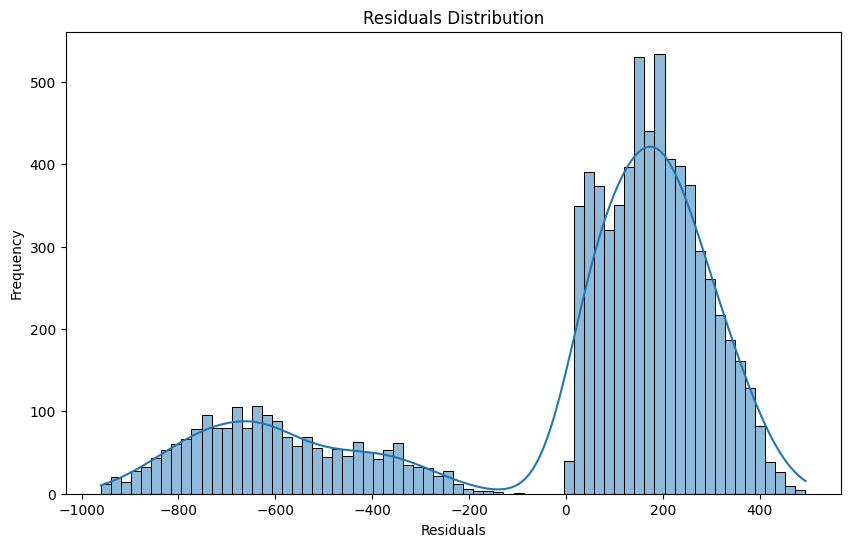

ValueError: Bin edges must be unique: array([  1.,  36., 342., 991., 991., 991., 991., 991., 991., 993., 993.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [19]:
a = df
a_x = a[X_cols2]
a_y = a['irmjfy']

scaler = StandardScaler()
a_x_scaled = scaler.fit_transform(a_x)

def train_with_each_y(Xdata, Ydata):
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
    
    # 하이퍼파라미터 그리드 설정
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    rt_reg = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rt_reg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    best_rt_reg = grid_search.best_estimator_
    pred_y = best_rt_reg.predict(X_test)

    print(' --      RF      -- ')
    print('r2 :', r2_score(pred_y, y_test), ' mse: ', mean_squared_error(pred_y, y_test), ' mae: ', mean_absolute_error(pred_y, y_test))
    
    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
    
    # 분위수 분석
    quantiles = np.linspace(0, 1, 11)
    y_quantiles = np.quantile(y_test, quantiles)
    quantile_groups = pd.cut(y_test, y_quantiles, include_lowest=True, duplicates='drop')
    
    quantile_metrics = {}
    for q in quantile_groups.unique():
        mask = quantile_groups == q
        q_r2 = r2_score(y_test[mask], pred_y[mask])
        q_mse = mean_squared_error(y_test[mask], pred_y[mask])
        q_mae = mean_absolute_error(y_test[mask], pred_y[mask])
        quantile_metrics[str(q)] = {'r2': q_r2, 'mse': q_mse, 'mae': q_mae}
    
    print('Quantile Analysis:')
    for quantile, metrics in quantile_metrics.items():
        print(f"{quantile}: {metrics}")

train_with_each_y(a_x_scaled, a_y)

Cross-validated R2 scores: [-0.04233811 -0.05562482 -0.05972037 -0.05370029 -0.07937046]
Mean R2 score: -0.05815080874320402
 --      RF      -- 
r2 : -3.0080595993263923  mse:  145557.56850809147  mae:  284.1202126266763


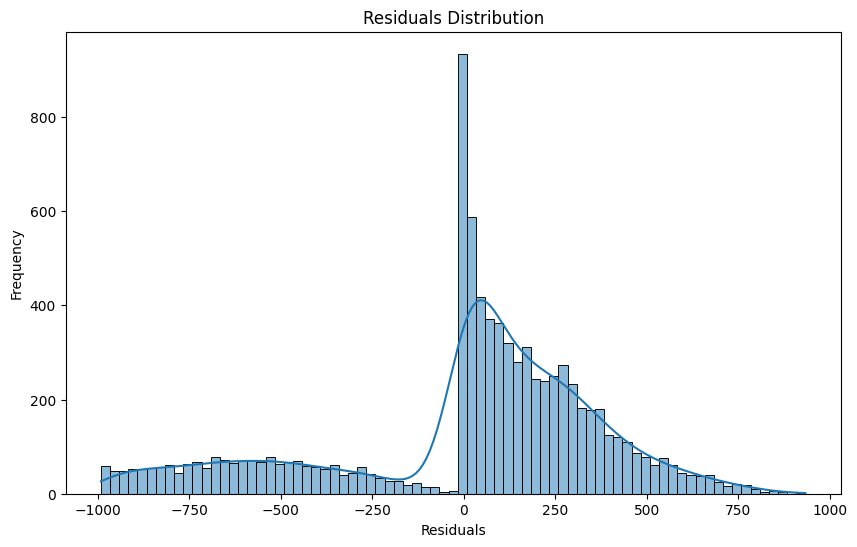

Quantile Analysis:
(991.0, 993.0]: {'r2': 0.0, 'mse': 86576.47258855747, 'mae': 229.88406659622743}
(342.0, 991.0]: {'r2': -2.001855850774439, 'mse': 70522.74299518105, 'mae': 191.75925828841065}
(0.999, 36.0]: {'r2': -5181.5078085336, 'mse': 536533.7373358454, 'mae': 704.563555398453}
(36.0, 342.0]: {'r2': -35.48298905394566, 'mse': 318096.5455759999, 'mae': 521.9708972615961}


In [21]:
#표준화, 교차검증

a = df
a_x = a[X_cols2]
a_y = a['irmjfy']

# 데이터 표준화
scaler = StandardScaler()
a_x_scaled = scaler.fit_transform(a_x)

def train_with_each_y(Xdata, Ydata):
    # Random Forest Regressor
    rt_reg = RandomForestRegressor()

    # 교차 검증
    cv_scores = cross_val_score(rt_reg, Xdata, Ydata, cv=5, scoring='r2')
    print('Cross-validated R2 scores:', cv_scores)
    print('Mean R2 score:', np.mean(cv_scores))

    # 모델 훈련 및 평가
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
    rt_reg.fit(X_train, y_train)
    pred_y = rt_reg.predict(X_test)
    print(' --      RF      -- ')
    print('r2 :', r2_score(pred_y, y_test), ' mse: ', mean_squared_error(pred_y, y_test), ' mae: ', mean_absolute_error(pred_y, y_test))

    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # 분위수 분석
    quantiles = np.linspace(0, 1, 11)
    y_quantiles = np.quantile(y_test, quantiles)
    quantile_groups = pd.cut(y_test, y_quantiles, include_lowest=True, duplicates='drop')

    quantile_metrics = {}
    for q in quantile_groups.unique():
        mask = quantile_groups == q
        q_r2 = r2_score(y_test[mask], pred_y[mask])
        q_mse = mean_squared_error(y_test[mask], pred_y[mask])
        q_mae = mean_absolute_error(y_test[mask], pred_y[mask])
        quantile_metrics[str(q)] = {'r2': q_r2, 'mse': q_mse, 'mae': q_mae}

    print('Quantile Analysis:')
    for quantile, metrics in quantile_metrics.items():
        print(f"{quantile}: {metrics}")

train_with_each_y(a_x_scaled, a_y)

C:\Users\pc\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 'auto', 4, 2, 300] before, using random point [48, 'auto', 1, 5, 278]
  warnings.warn(


Cross-validated R2 scores: [0.09493942 0.08700943 0.08444732 0.09090975 0.08083344]
Mean R2 score: 0.08762787252734709
 --      RF      -- 
r2 : 0.08226047591106245  mse:  127202.40679444296  mae:  280.7438770075175


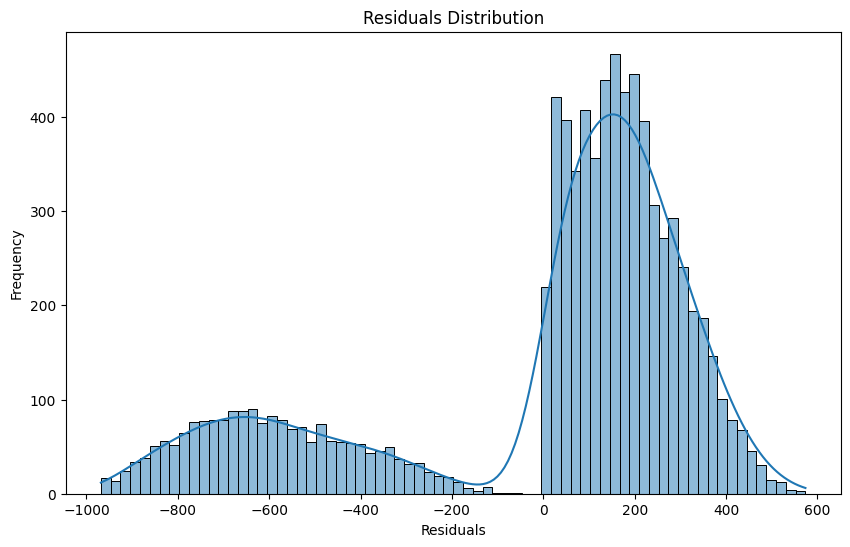

ValueError: Bin edges must be unique: array([  1.,  36., 342., 991., 991., 991., 991., 991., 991., 993., 993.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [25]:
from skopt import BayesSearchCV #베이지안 하이퍼파라미터튜닝

a = df
a_x = a[X_cols2]
a_y = a['irmjfy']

scaler = StandardScaler()
a_x_scaled = scaler.fit_transform(a_x)

def train_with_each_y(Xdata, Ydata):
    # 랜덤 포레스트 모델 정의
    rt_reg = RandomForestRegressor()

    # 하이퍼파라미터 공간 정의
    param_space = {
        'n_estimators': (50, 300),
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': (5, 50),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4)
    }

    # 베이지안 최적화를 이용한 하이퍼파라미터 튜닝
    opt = BayesSearchCV(
        estimator=rt_reg,
        search_spaces=param_space,
        n_iter=32,
        cv=5,
        n_jobs=-1,
        verbose=0,
        scoring='r2',
        random_state=42
    )
    
    opt.fit(Xdata, Ydata)
    
    best_rt_reg = opt.best_estimator_
    
    # 교차 검증
    cv_scores = cross_val_score(best_rt_reg, Xdata, Ydata, cv=5, scoring='r2')
    print('Cross-validated R2 scores:', cv_scores)
    print('Mean R2 score:', np.mean(cv_scores))

    # 모델 훈련 및 평가
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
    best_rt_reg.fit(X_train, y_train)
    pred_y = best_rt_reg.predict(X_test)
    print(' --      RF      -- ')
    print('r2 :', r2_score(y_test, pred_y), ' mse: ', mean_squared_error(y_test, pred_y), ' mae: ', mean_absolute_error(y_test, pred_y))

    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # 분위수 분석
    quantiles = np.linspace(0, 1, 11)
    y_quantiles = np.quantile(y_test, quantiles)
    quantile_groups = pd.cut(y_test, y_quantiles, include_lowest=True, duplicates='drop')

    quantile_metrics = {}
    for q in quantile_groups.unique():
        mask = quantile_groups == q
        q_r2 = r2_score(y_test[mask], pred_y[mask])
        q_mse = mean_squared_error(y_test[mask], pred_y[mask])
        q_mae = mean_absolute_error(y_test[mask], pred_y[mask])
        quantile_metrics[str(q)] = {'r2': q_r2, 'mse': q_mse, 'mae': q_mae}

    print('Quantile Analysis:')
    for quantile, metrics in quantile_metrics.items():
        print(f"{quantile}: {metrics}")
    
train_with_each_y(a_x_scaled, a_y)

## 구글 문서 첨부 2

Cross-validated R2 scores: [0.08809055 0.08461249 0.08113638 0.08642687 0.08295389]
Mean R2 score: 0.0846440341939976
 --      RF      -- 
r2 : 0.08043327466121564  mse:  127455.66427173105  mae:  286.01083116534403


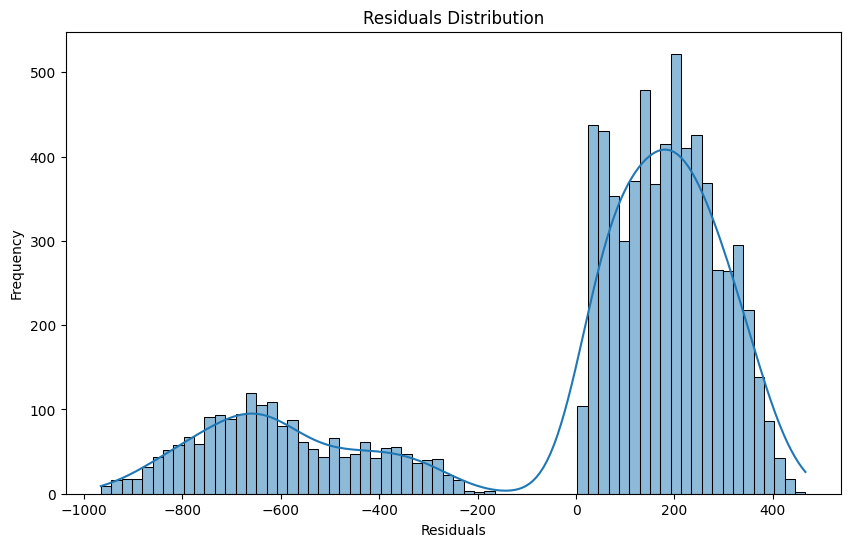

Quantile Analysis:
(991.0, 993.0]: {'r2': 0.0, 'mse': 53911.71169017967, 'mae': 213.90950199796342}
(342.0, 991.0]: {'r2': -1.0607869138457389, 'mse': 48414.165475494614, 'mae': 189.80002582037318}
(0.999, 36.0]: {'r2': -5225.372166294414, 'mse': 541074.9186856338, 'mae': 729.4612282756929}
(36.0, 342.0]: {'r2': -36.90644697613957, 'mse': 330507.7284194107, 'mae': 559.7359302315734}
 --      GB      -- 
r2 : 0.0821223464151446  mse:  127221.5521007841  mae:  284.4458921482626


In [22]:
# 베이지안 최적화, 정규화, 교차검증, GB
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV

a = df
a_x = a[X_cols2]
a_y = a['irmjfy']


# 데이터 표준화
scaler = StandardScaler()
a_x_scaled = scaler.fit_transform(a_x)

def train_with_each_y(Xdata, Ydata):
    # 랜덤 포레스트 모델 정의
    rt_reg = RandomForestRegressor()

    # 하이퍼파라미터 공간 정의
    param_space = {
        'n_estimators': (50, 300),
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': (5, 50),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4),
        'bootstrap': [True]
    }

    # 베이지안 최적화를 이용한 하이퍼파라미터 튜닝
    opt = BayesSearchCV(
        estimator=rt_reg,
        search_spaces=param_space,
        n_iter=50,  # 더 많은 반복을 수행하여 최적의 파라미터 탐색
        cv=5,
        n_jobs=-1,
        verbose=0,
        scoring='r2',
        random_state=42
    )
    
    opt.fit(Xdata, Ydata)
    
    best_rt_reg = opt.best_estimator_
    
    # 교차 검증
    cv_scores = cross_val_score(best_rt_reg, Xdata, Ydata, cv=5, scoring='r2')
    print('Cross-validated R2 scores:', cv_scores)
    print('Mean R2 score:', np.mean(cv_scores))

    # 모델 훈련 및 평가
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
    best_rt_reg.fit(X_train, y_train)
    pred_y = best_rt_reg.predict(X_test)
    print(' --      RF      -- ')
    print('r2 :', r2_score(y_test, pred_y), ' mse: ', mean_squared_error(y_test, pred_y), ' mae: ', mean_absolute_error(y_test, pred_y))

    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # 분위수 분석
    quantiles = np.linspace(0, 1, 11)
    y_quantiles = np.quantile(y_test, quantiles)
    quantile_groups = pd.cut(y_test, y_quantiles, include_lowest=True, duplicates='drop')

    quantile_metrics = {}
    for q in quantile_groups.unique():
        mask = quantile_groups == q
        q_r2 = r2_score(y_test[mask], pred_y[mask])
        q_mse = mean_squared_error(y_test[mask], pred_y[mask])
        q_mae = mean_absolute_error(y_test[mask], pred_y[mask])
        quantile_metrics[str(q)] = {'r2': q_r2, 'mse': q_mse, 'mae': q_mae}

    print('Quantile Analysis:')
    for quantile, metrics in quantile_metrics.items():
        print(f"{quantile}: {metrics}")

    # Gradient Boosting
    gb_reg = GradientBoostingRegressor()
    gb_reg.fit(X_train, y_train)
    pred_y_gb = gb_reg.predict(X_test)
    print(' --      GB      -- ')
    print('r2 :', r2_score(y_test, pred_y_gb), ' mse: ', mean_squared_error(y_test, pred_y_gb), ' mae: ', mean_absolute_error(y_test, pred_y_gb))

train_with_each_y(a_x_scaled, a_y)

In [ ]:
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV

a = df
a_x = a[X_cols2]
a_y = a['irmjfy']

# 데이터 표준화
scaler = StandardScaler()
a_x_scaled = scaler.fit_transform(a_x)

def train_with_each_y(Xdata, Ydata):
    # 랜덤 포레스트 모델 정의
    rt_reg = RandomForestRegressor()

    # 하이퍼파라미터 공간 정의
    param_space = {
        'n_estimators': (50, 300),
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': (5, 50),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4),
        'bootstrap': [True] #True False 중 선택
    }

    # 베이지안 최적화를 이용한 하이퍼파라미터 튜닝
    opt = BayesSearchCV(
        estimator=rt_reg,
        search_spaces=param_space,
        n_iter=50,  # 더 많은 반복을 수행하여 최적의 파라미터 탐색
        cv=5,
        n_jobs=-1,
        verbose=0,
        scoring='r2',
        random_state=42
    )
    
    opt.fit(Xdata, Ydata)
    
    best_rt_reg = opt.best_estimator_
    
    # 교차 검증
    cv_scores = cross_val_score(best_rt_reg, Xdata, Ydata, cv=5, scoring='r2')
    print('Cross-validated R2 scores:', cv_scores)
    print('Mean R2 score:', np.mean(cv_scores))

    # 모델 훈련 및 평가
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
    best_rt_reg.fit(X_train, y_train)
    pred_y = best_rt_reg.predict(X_test)
    print(' --      RF      -- ')
    print('r2 :', r2_score(y_test, pred_y), ' mse: ', mean_squared_error(y_test, pred_y), ' mae: ', mean_absolute_error(y_test, pred_y))

    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # 분위수 분석
    quantiles = np.linspace(0, 1, 11)
    y_quantiles = np.quantile(y_test, quantiles)
    quantile_groups = pd.cut(y_test, y_quantiles, include_lowest=True, duplicates='drop')

    quantile_metrics = {}
    for q in quantile_groups.unique():
        mask = quantile_groups == q
        q_r2 = r2_score(y_test[mask], pred_y[mask])
        q_mse = mean_squared_error(y_test[mask], pred_y[mask])
        q_mae = mean_absolute_error(y_test[mask], pred_y[mask])
        quantile_metrics[str(q)] = {'r2': q_r2, 'mse': q_mse, 'mae': q_mae}

    print('Quantile Analysis:')
    for quantile, metrics in quantile_metrics.items():
        print(f"{quantile}: {metrics}")

train_with_each_y(a_x_scaled, a_y)

C:\Users\pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\pc\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [True, 40, 'sqrt', 4, 10, 300] before, using random point [True, 35, 'auto', 3, 8, 182]
  warnings.warn(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavi

Cross-validated R2 scores: [0.08093028 0.0804429  0.07783576 0.07583865 0.07165415]
Mean R2 score: 0.07734034733389857


C:\Users\pc\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


 --      RF      -- 
r2 : 0.07356187633337952  mse:  139989.53894642348  mae:  314.9824877391617


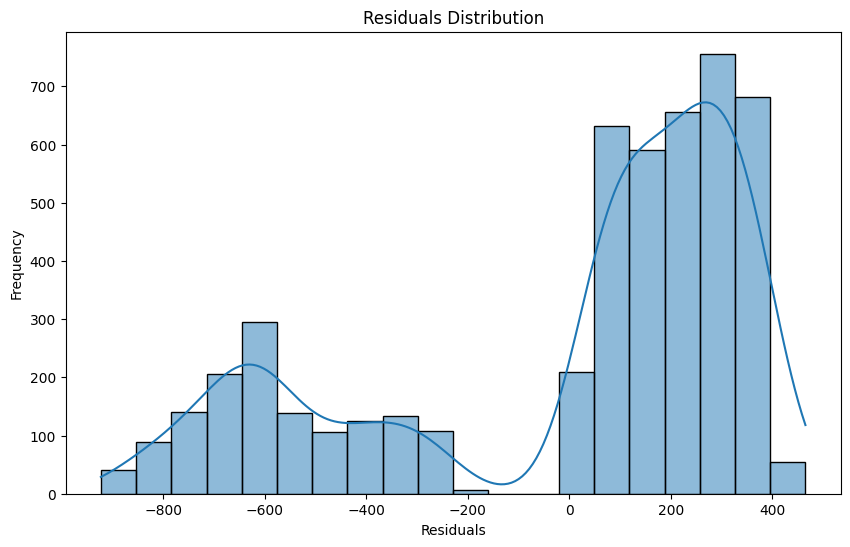

Quantile Analysis:
(260.0, 991.0]: {'r2': -0.5099234131984192, 'mse': 69027.06709444015, 'mae': 235.23351970383976}
(0.999, 27.4]: {'r2': -9575.59941025304, 'mse': 498754.46458421194, 'mae': 700.9074603510677}
(991.0, 993.0]: {'r2': 0.0, 'mse': 58534.60966467601, 'mae': 218.24261289679882}
(27.4, 260.0]: {'r2': -51.64381090462456, 'mse': 347920.19965980103, 'mae': 576.1086370714423}
Cross-validated R2 scores: [0.05995625 0.06058337 0.06092034 0.06832979 0.05898727]
Mean R2 score: 0.061755403459765934
 --      RF      -- 
r2 : 0.07551387352157579  mse:  108572.66756541468  mae:  239.5385067538422


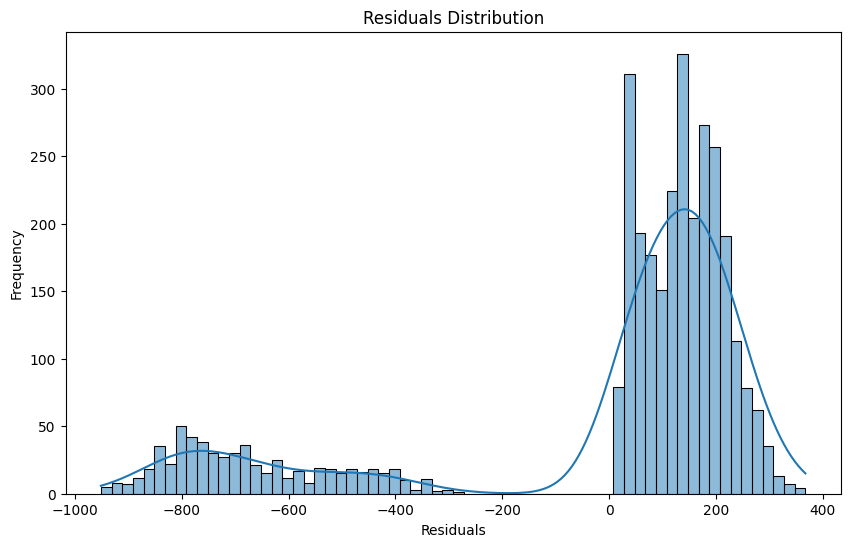

Quantile Analysis:
(60.6, 991.0]: {'r2': 0.04237420633672229, 'mse': 55115.139625456526, 'mae': 178.56006048445263}
(991.0, 993.0]: {'r2': 0.0, 'mse': 35933.89578325331, 'mae': 182.20301622766038}
(0.999, 60.6]: {'r2': -1653.889903341334, 'mse': 616042.5229804472, 'mae': 781.8444060210032}


In [19]:
#데이터 군집화
from sklearn.cluster import KMeans
from skopt import BayesSearchCV

a = df
a_x = a[X_cols2]
a_y = a['irmjfy']

# 데이터 군집화
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(a_x_scaled)
a['cluster'] = clusters

# 각 군집별 모델 학습
for cluster in a['cluster'].unique():
    cluster_data = a[a['cluster'] == cluster]
    cluster_x = cluster_data[X_cols2]
    cluster_y = cluster_data['irmjfy']
    
    scaler = StandardScaler()
    cluster_x_scaled = scaler.fit_transform(cluster_x)
    
    train_with_each_y(cluster_x_scaled, cluster_y)

Cross-validated R2 scores: [0.05762629 0.05460377 0.05019844 0.05442038 0.05353982]
Mean R2 score: 0.05407774034589345
 --      RF      -- 
r2 : 0.05085639361079686  mse:  2.3663138802998023  mae:  1.0293757191016173


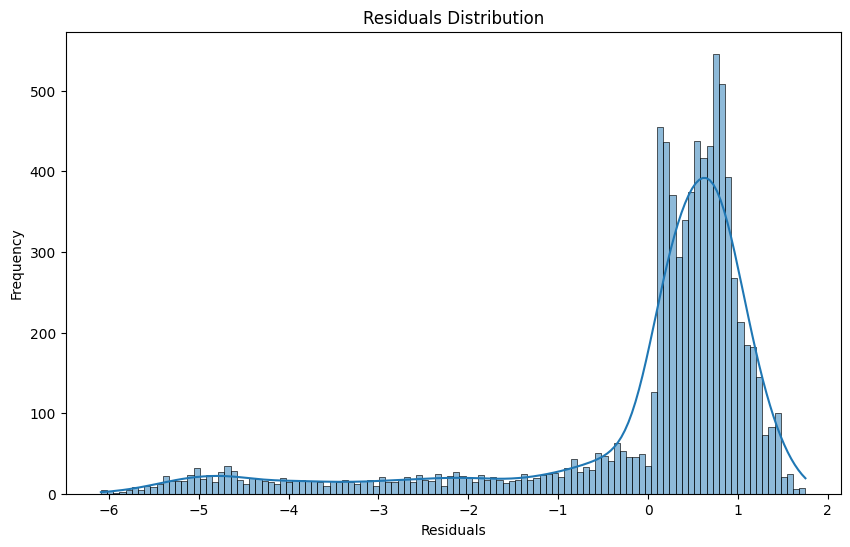

Quantile Analysis:
(6.9, 6.902]: {'r2': -2.0716764680599297e+29, 'mse': 0.6537058295675299, 'mae': 0.7424967930299989}
(5.838, 6.9]: {'r2': -7.1364193519303605, 'mse': 0.4874713031196922, 'mae': 0.6017589436132315}
(0.692, 3.611]: {'r2': -19.156483022538943, 'mse': 17.497715107346686, 'mae': 4.0640539116963454}
(3.611, 5.838]: {'r2': -2.9326321007758227, 'mse': 1.659402825073858, 'mae': 1.081707815796096}


In [20]:
# 로그변환
a = df
a_x = a[X_cols2]
a_y = a['irmjfy']

# 데이터 표준화
scaler = StandardScaler()
a_x_scaled = scaler.fit_transform(a_x)
a_y_log = np.log1p(a_y)


def train_with_each_y(Xdata, Ydata):
    # 랜덤 포레스트 모델 정의
    rt_reg = RandomForestRegressor()

    # 하이퍼파라미터 공간 정의
    param_space = {
        'n_estimators': (50, 300),
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': (5, 50),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4),
        'bootstrap': [True] #True False 중 선택
    }

    # 베이지안 최적화를 이용한 하이퍼파라미터 튜닝
    opt = BayesSearchCV(
        estimator=rt_reg,
        search_spaces=param_space,
        n_iter=50,  # 더 많은 반복을 수행하여 최적의 파라미터 탐색
        cv=5,
        n_jobs=-1,
        verbose=0,
        scoring='r2',
        random_state=42
    )
    
    opt.fit(Xdata, Ydata)
    
    best_rt_reg = opt.best_estimator_
    
    # 교차 검증
    cv_scores = cross_val_score(best_rt_reg, Xdata, Ydata, cv=5, scoring='r2')
    print('Cross-validated R2 scores:', cv_scores)
    print('Mean R2 score:', np.mean(cv_scores))

    # 모델 훈련 및 평가
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
    best_rt_reg.fit(X_train, y_train)
    pred_y = best_rt_reg.predict(X_test)
    print(' --      RF      -- ')
    print('r2 :', r2_score(y_test, pred_y), ' mse: ', mean_squared_error(y_test, pred_y), ' mae: ', mean_absolute_error(y_test, pred_y))

    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # 분위수 분석
    quantiles = np.linspace(0, 1, 11)
    y_quantiles = np.quantile(y_test, quantiles)
    quantile_groups = pd.cut(y_test, y_quantiles, include_lowest=True, duplicates='drop')

    quantile_metrics = {}
    for q in quantile_groups.unique():
        mask = quantile_groups == q
        q_r2 = r2_score(y_test[mask], pred_y[mask])
        q_mse = mean_squared_error(y_test[mask], pred_y[mask])
        q_mae = mean_absolute_error(y_test[mask], pred_y[mask])
        quantile_metrics[str(q)] = {'r2': q_r2, 'mse': q_mse, 'mae': q_mae}

    print('Quantile Analysis:')
    for quantile, metrics in quantile_metrics.items():
        print(f"{quantile}: {metrics}")

train_with_each_y(a_x_scaled, a_y_log)

In [10]:
df['irmjfy_3'] = df['irmjfy'].apply(lambda x: -1 if x == 991 else (0 if x == 993 else x))

## PPT에 넣을 내용

In [1]:
X_cols=['PDEN10','COUTYP4','AIIND102','CATAG2','CATAG3','CATAG6','CATAG7','PREGAGE2','NEWRACE2','ENRLCOLLFT2','ENRLCOLLST2','IRWRKSTAT18',
        'EDFAM18','NRCH17_2','IRHHSIZ2','IRKI17_2','IRHH65_2', 'catage','drvinage','drvindetag','sexage','eduhighcat','irwrkstat',
        'imother','ifather','govtprog','income','snysell','snystole','snyattak','snfamjev','snrlgsvc','snrlgimp','snrldcsn','snrlfrnd']

In [3]:
len(X_cols)

35

 --      RF      -- 
r2 : 0.05258157255124862  mse:  131316.02273806898  mae:  268.8522941356744


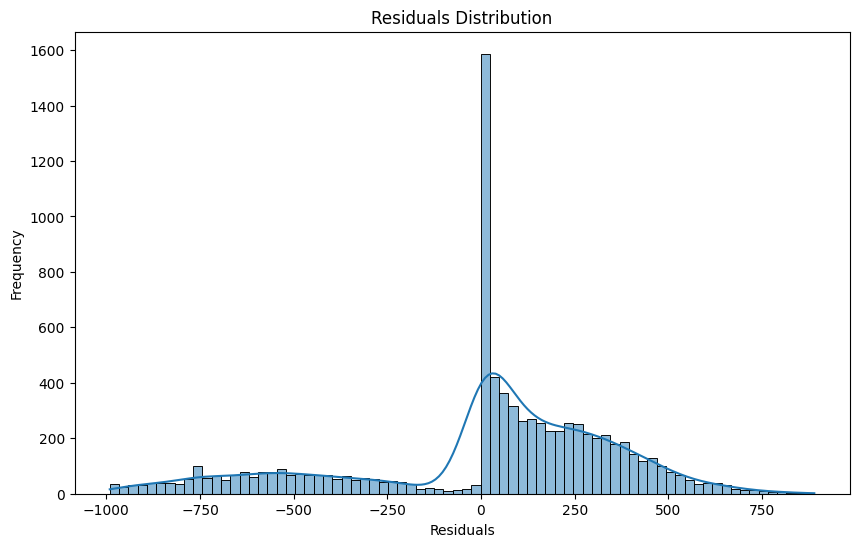

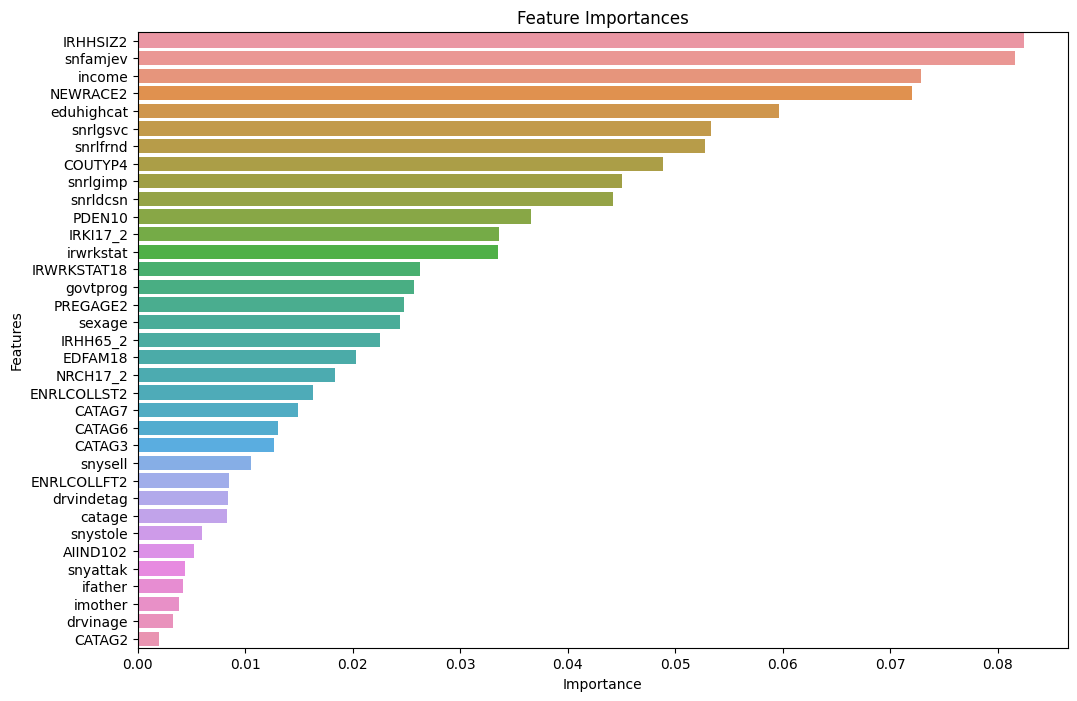

In [33]:
a = df
a_x = a[X_cols]
a_y = a['irmjfy']

def train_with_each_y(Xdata, Ydata):
    # 모델 훈련 및 평가
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
    rt_reg=RandomForestRegressor()
    rt_reg.fit(X_train, y_train)
    pred_y = rt_reg.predict(X_test)
    print(' --      RF      -- ')
    print('r2 :', r2_score(y_test, pred_y), ' mse: ', mean_squared_error(y_test, pred_y), ' mae: ', mean_absolute_error(y_test, pred_y))

    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # 중요 특징 시각화
    feature_importances = rt_reg.feature_importances_
    features = Xdata.columns
    importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Features', data=importance_df)
    plt.title('Feature Importances')
    plt.show()


train_with_each_y(a_x, a_y)

In [15]:
df['irmjfy_2'] = df['irmjfy'].replace({991: -1, 993: 0})

In [13]:
df['irmjfy_2']

0         -1
1        364
2         -1
3         -1
4        108
        ... 
42806     -1
42807      1
42808    364
42809     44
42810    208
Name: irmjfy_2, Length: 41443, dtype: int64

In [17]:
sum(df['irmjfy_2'].isnull())

0

In [14]:
from scipy.stats import yeojohnson
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline

a_y와 각 변수 간의 상관계수:
eduhighcat     0.157704
drvinage       0.140152
snrlgsvc       0.130803
ifather        0.128249
IRWRKSTAT18    0.127463
imother        0.127279
snrldcsn       0.127003
snrlgimp       0.126259
snrlfrnd       0.126189
snyattak       0.123660
snystole       0.123364
snysell        0.122514
snfamjev       0.119912
irwrkstat      0.115523
drvindetag     0.107422
income         0.105860
IRKI17_2       0.094309
PREGAGE2       0.090847
govtprog       0.070562
sexage         0.067154
IRHHSIZ2       0.065406
CATAG7         0.064638
CATAG2         0.061007
ENRLCOLLST2    0.058015
IRHH65_2       0.057882
ENRLCOLLFT2    0.055986
CATAG6         0.023169
COUTYP4        0.017491
NEWRACE2       0.017090
PDEN10         0.017026
catage         0.015332
EDFAM18        0.012145
CATAG3         0.010257
AIIND102       0.009263
NRCH17_2       0.007759
Name: irmjfy_2, dtype: float64


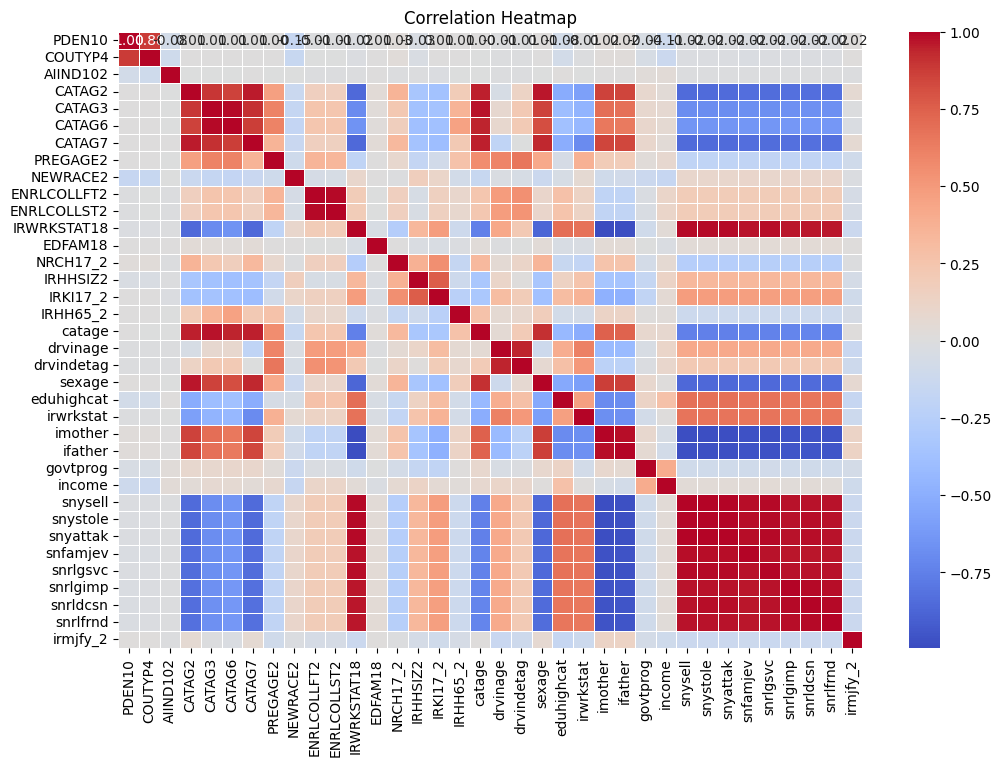

In [34]:
# a_y 정의
a_y = df['irmjfy_2']

# X_cols에 a_y 추가
corr_df = df[X_cols + ['irmjfy_2']]

# 상관계수 행렬 계산
corr_matrix = corr_df.corr()

# a_y와 각 변수 간의 상관계수 추출 및 정렬
a_y_corr = corr_matrix['irmjfy_2'].drop('irmjfy_2')
a_y_corr_sorted = a_y_corr.abs().sort_values(ascending=False)
print("a_y와 각 변수 간의 상관계수:")
print(a_y_corr_sorted)

# 히트맵 출력
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [11]:
X_cols3= ['imother','ifather', 'IRWRKSTAT18', 'drvindetag', 'eduhighcat','snrlfrnd','snysell','snystole','snyattak','snrlgsvc','snrlgimp','snrldcsn']
print(df[X_cols3])

       imother  ifather  IRWRKSTAT18  drvindetag  eduhighcat  snrlfrnd  \
0            4        4            3           2           1         3   
1            4        4            1           3           4         2   
2            4        4            1           2           4         2   
3            4        4            1           3           2         4   
4            4        4            1           3           4         1   
...        ...      ...          ...         ...         ...       ...   
42806        4        4            4           3           4         2   
42807        4        4            1           3           4         2   
42808        4        4            2           2           4         2   
42809        1        2           99           4           5        99   
42810        4        4            1           3           4         2   

       snysell  snystole  snyattak  snrlgsvc  snrlgimp  snrldcsn  
0            1         1         1         3

 --      RF      -- 
r2 : 0.038439262937442376  mse:  130242.86824545827  mae:  274.49217341315074


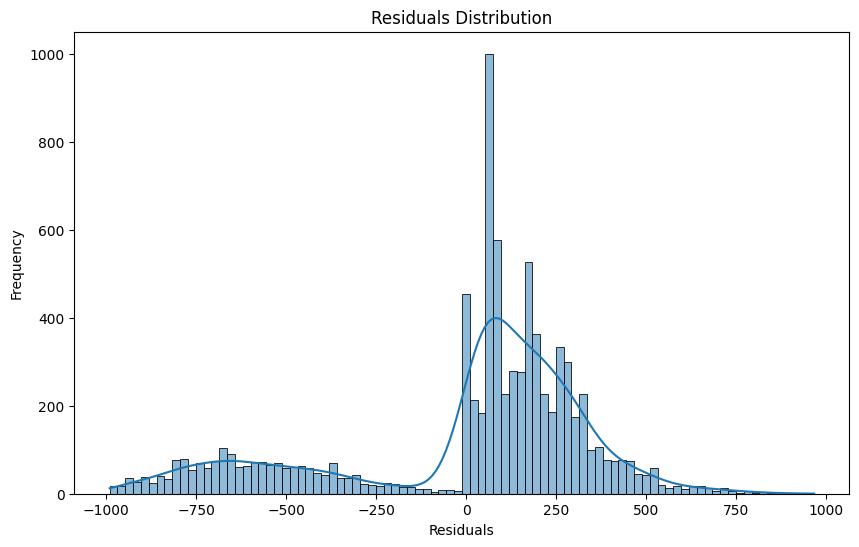

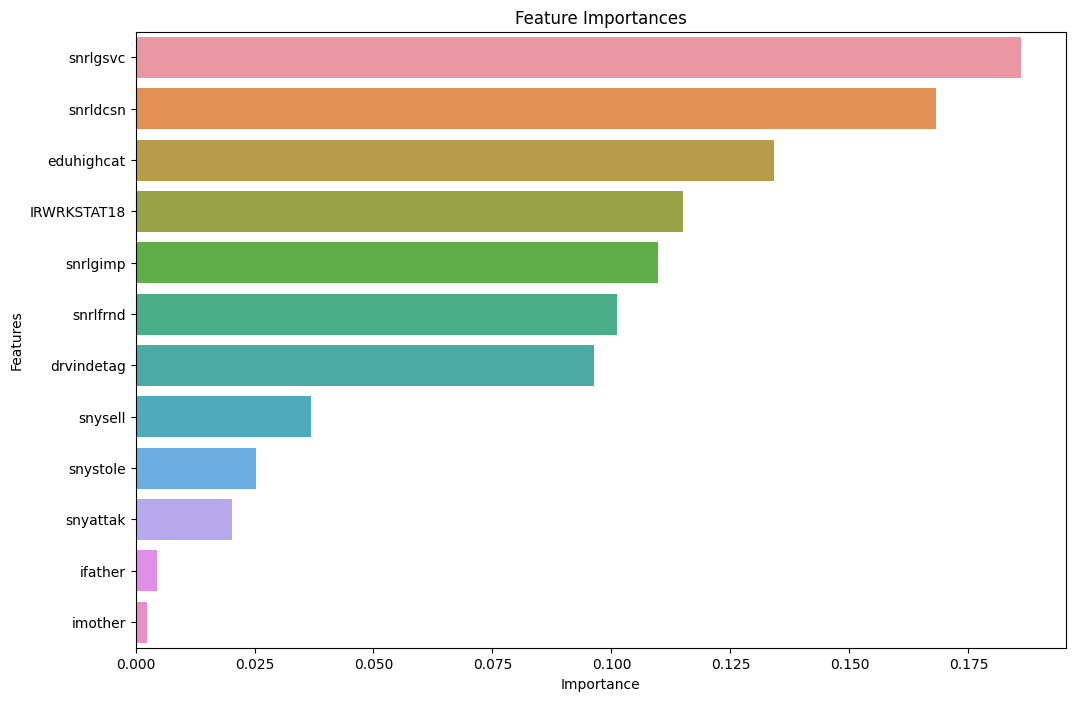

In [12]:
a = df
a_x = a[X_cols3]
a_y = a['irmjfy']

def train_with_each_y(Xdata, Ydata):
    # 모델 훈련 및 평가
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
    rt_reg=RandomForestRegressor()
    rt_reg.fit(X_train, y_train)
    pred_y = rt_reg.predict(X_test)
    print(' --      RF      -- ')
    print('r2 :', r2_score(y_test, pred_y), ' mse: ', mean_squared_error(y_test, pred_y), ' mae: ', mean_absolute_error(y_test, pred_y))

    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # 중요 특징 시각화
    feature_importances = rt_reg.feature_importances_
    features = Xdata.columns
    importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Features', data=importance_df)
    plt.title('Feature Importances')
    plt.show()


train_with_each_y(a_x, a_y)

Cross-validated R2 scores: [0.10174016 0.09396685 0.1004794  0.10017249 0.10374422]
Mean R2 score: 0.1000206260284107
 --      RF      -- 
r2 : 0.09021329433411018  mse:  1017934.2159545831  mae:  804.7163115879504


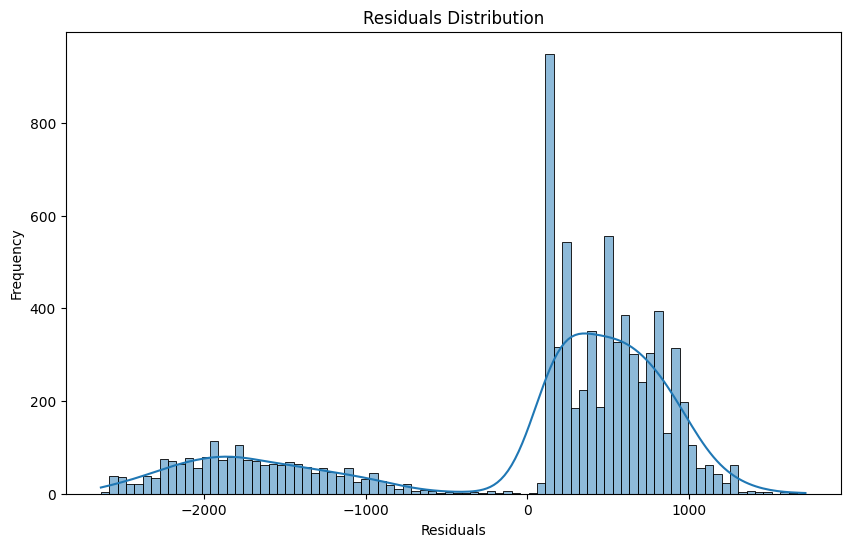

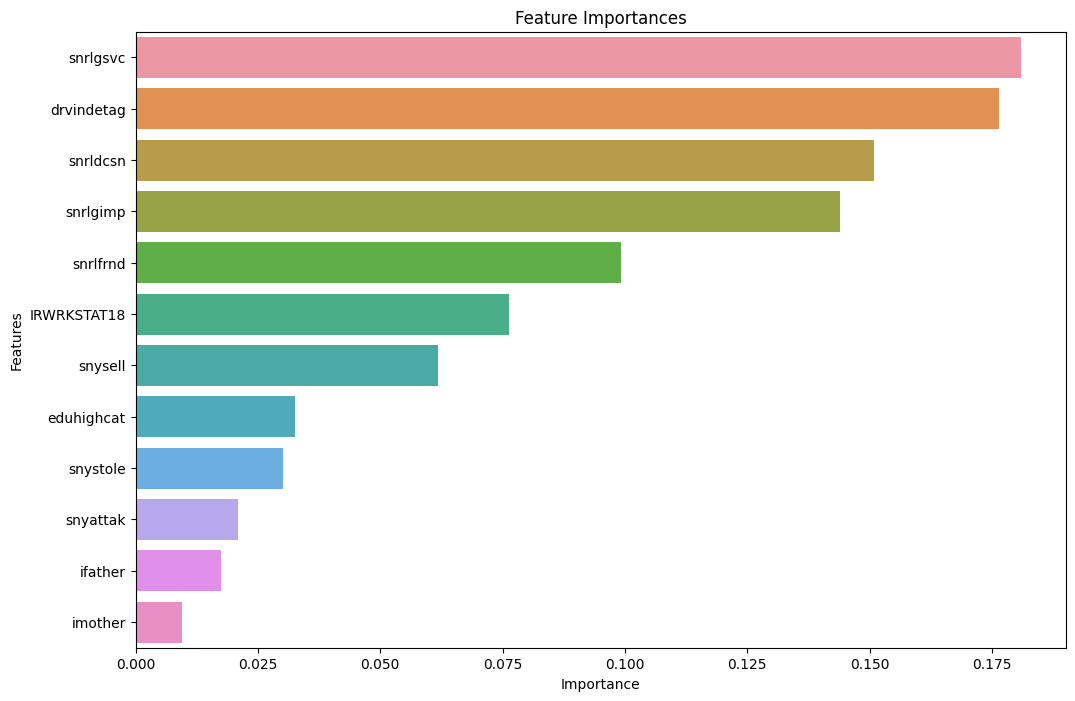

In [36]:
a = df
a_x = a[X_cols3]
a_y = a['irmjfy']

# Box-Cox 변환
a_y_boxcox, _ = boxcox(a_y + 1)

# 파이프라인을 사용하여 스케일링과 모델을 결합
def train_with_each_y(Xdata, Ydata):
    # 파이프라인 정의
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # 스케일링
        ('regressor', RandomForestRegressor())  # 랜덤 포레스트
    ])

    # 하이퍼파라미터 공간 정의
    param_space = {
        'regressor__n_estimators': (50, 300),
        'regressor__max_features': ['auto', 'sqrt', 'log2'],
        'regressor__max_depth': (5, 50),
        'regressor__min_samples_split': (2, 10),
        'regressor__min_samples_leaf': (1, 4),
        'regressor__bootstrap': [True]
    }

    # 베이지안 최적화를 이용한 하이퍼파라미터 튜닝
    opt = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_space,
        n_iter=50,  # 더 많은 반복을 수행하여 최적의 파라미터 탐색
        cv=5,
        n_jobs=-1,
        verbose=0,
        scoring='r2',
        random_state=42
    )
    
    opt.fit(Xdata, Ydata)
    
    best_pipeline = opt.best_estimator_
    
    # 교차 검증
    cv_scores = cross_val_score(best_pipeline, Xdata, Ydata, cv=5, scoring='r2')
    print('Cross-validated R2 scores:', cv_scores)
    print('Mean R2 score:', np.mean(cv_scores))

    # 모델 훈련 및 평가
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
    best_pipeline.fit(X_train, y_train)
    pred_y = best_pipeline.predict(X_test)
    print(' --      RF      -- ')
    print('r2 :', r2_score(y_test, pred_y), ' mse: ', mean_squared_error(y_test, pred_y), ' mae: ', mean_absolute_error(y_test, pred_y))

    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()


    # 중요 특징 시각화
    feature_importances = best_pipeline.named_steps['regressor'].feature_importances_
    features = Xdata.columns
    importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Features', data=importance_df)
    plt.title('Feature Importances')
    plt.show()


train_with_each_y(a_x, a_y_boxcox)

Cross-validated R2 scores: [0.15739016 0.1448456  0.15597453 0.15825339 0.16761284]
Mean R2 score: 0.15681530346880918
 --      RF      -- 
r2 : 0.14472311994157538  mse:  0.2213961382496597  mae:  0.38205169484606755


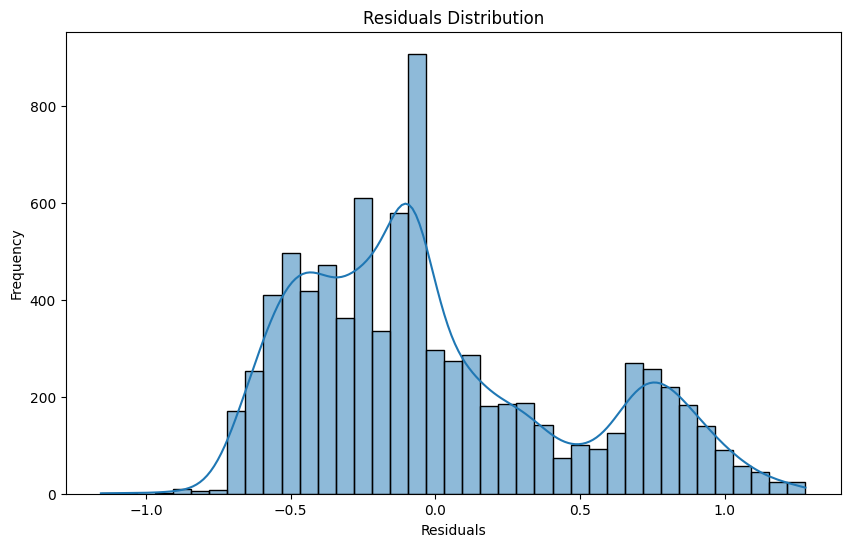

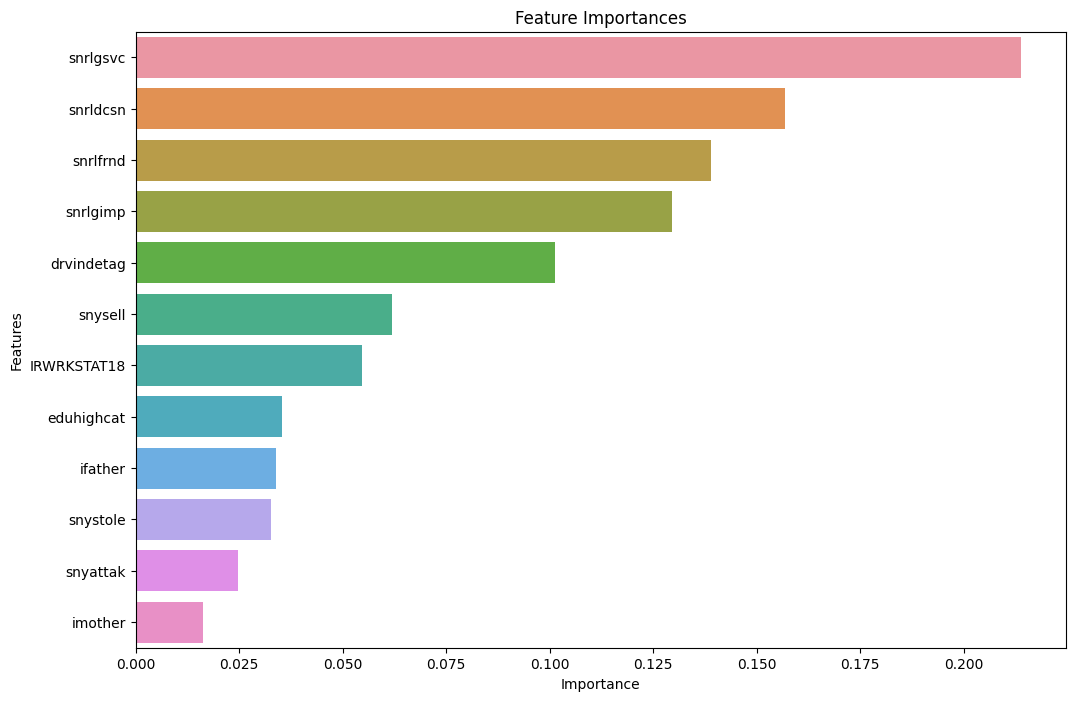

In [37]:
a = df
a_x = a[X_cols3]
a_y = a['irmjfy_2']

# Box-Cox 변환
a_y_yeojohnson, _ = yeojohnson(a_y + 1)

# 파이프라인을 사용하여 스케일링과 모델을 결합
def train_with_each_y(Xdata, Ydata):
    # 파이프라인 정의
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # 스케일링
        ('regressor', RandomForestRegressor())  # 랜덤 포레스트
    ])

    # 하이퍼파라미터 공간 정의
    param_space = {
        'regressor__n_estimators': (50, 300),
        'regressor__max_features': ['auto', 'sqrt', 'log2'],
        'regressor__max_depth': (5, 50),
        'regressor__min_samples_split': (2, 10),
        'regressor__min_samples_leaf': (1, 4),
        'regressor__bootstrap': [True]
    }

    # 베이지안 최적화를 이용한 하이퍼파라미터 튜닝
    opt = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_space,
        n_iter=50,  # 더 많은 반복을 수행하여 최적의 파라미터 탐색
        cv=5,
        n_jobs=-1,
        verbose=0,
        scoring='r2',
        random_state=42
    )
    
    opt.fit(Xdata, Ydata)
    
    best_pipeline = opt.best_estimator_
    
    # 교차 검증
    cv_scores = cross_val_score(best_pipeline, Xdata, Ydata, cv=5, scoring='r2')
    print('Cross-validated R2 scores:', cv_scores)
    print('Mean R2 score:', np.mean(cv_scores))

    # 모델 훈련 및 평가
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
    best_pipeline.fit(X_train, y_train)
    pred_y = best_pipeline.predict(X_test)
    print(' --      RF      -- ')
    print('r2 :', r2_score(y_test, pred_y), ' mse: ', mean_squared_error(y_test, pred_y), ' mae: ', mean_absolute_error(y_test, pred_y))

    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()


    # 중요 특징 시각화
    feature_importances = best_pipeline.named_steps['regressor'].feature_importances_
    features = Xdata.columns
    importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Features', data=importance_df)
    plt.title('Feature Importances')
    plt.show()


train_with_each_y(a_x, a_y_yeojohnson)

In [38]:
X_cols4=['IRWRKSTAT18', 'drvindetag', 'snrlfrnd','snysell','snrlgsvc','snrlgimp','snrldcsn'] #0.05보다 아래인 하위 5개 제거
print(df[X_cols4])

       IRWRKSTAT18  drvindetag  snrlfrnd  snysell  snrlgsvc  snrlgimp  \
0                3           2         3        1         3         3   
1                1           3         2        1         3         3   
2                1           2         2        1         1         2   
3                1           3         4        1         1         4   
4                1           3         1        1         1         1   
...            ...         ...       ...      ...       ...       ...   
42806            4           3         2        1         5         3   
42807            1           3         2        1         3         3   
42808            2           2         2        1         2         3   
42809           99           4        99       99        99        99   
42810            1           3         2        1         4         3   

       snrldcsn  
0             3  
1             3  
2             2  
3             4  
4             1  
...         ...

Cross-validated R2 scores: [0.15323407 0.13797615 0.14605488 0.14950664 0.15895443]
Mean R2 score: 0.14914523431759558
 --      RF      -- 
r2 : 0.13637937736472616  mse:  0.22355599130793188  mae:  0.38446719896679177


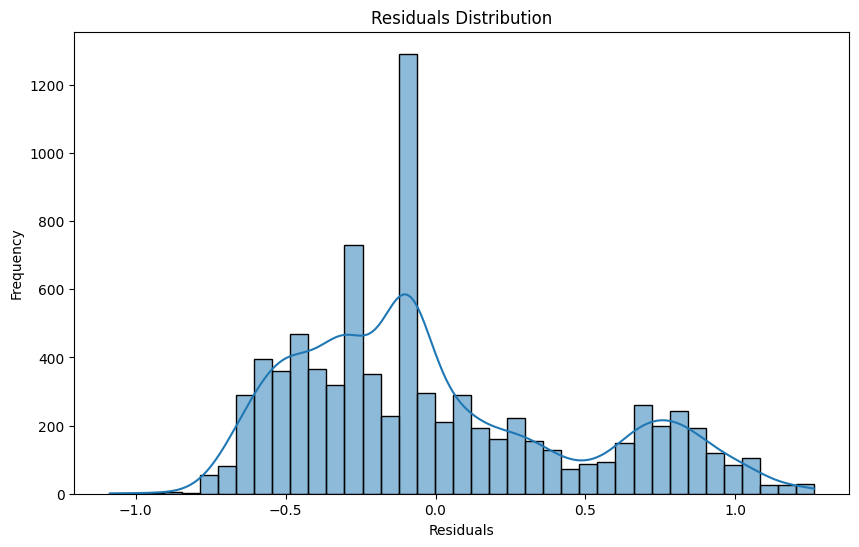

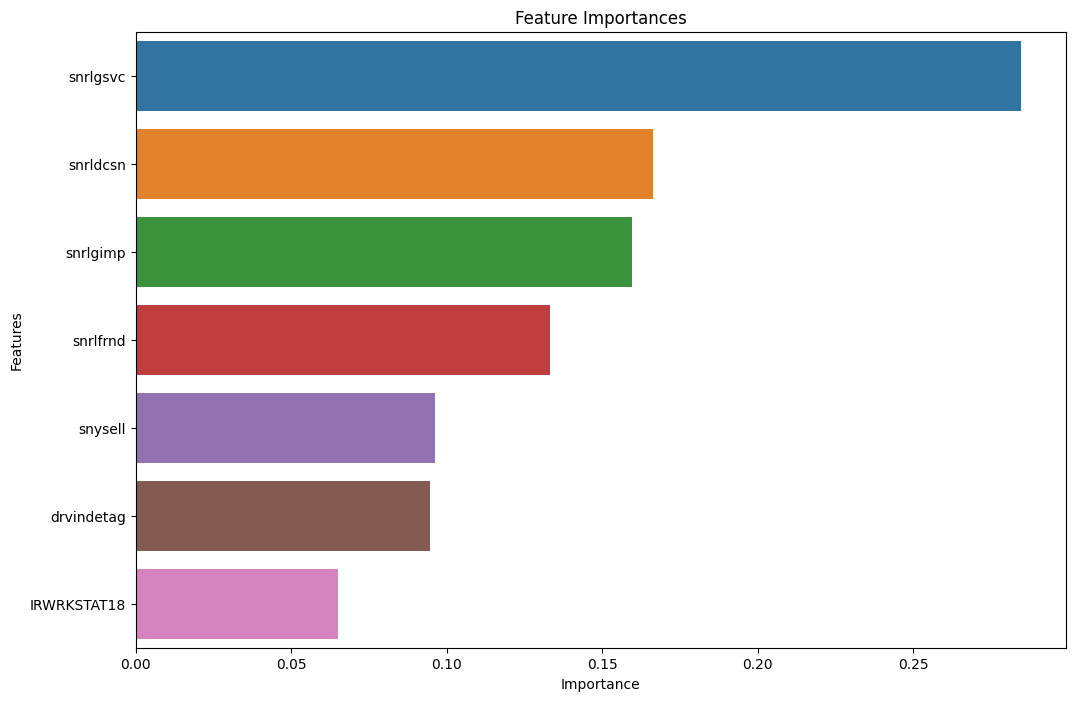

In [39]:
a = df
a_x = a[X_cols4]
a_y = a['irmjfy_2']

# Box-Cox 변환
a_y_yeojohnson, _ = yeojohnson(a_y + 1)

# 파이프라인을 사용하여 스케일링과 모델을 결합
def train_with_each_y(Xdata, Ydata):
    # 파이프라인 정의
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # 스케일링
        ('regressor', RandomForestRegressor())  # 랜덤 포레스트
    ])

    # 하이퍼파라미터 공간 정의
    param_space = {
        'regressor__n_estimators': (50, 300),
        'regressor__max_features': ['auto', 'sqrt', 'log2'],
        'regressor__max_depth': (5, 50),
        'regressor__min_samples_split': (2, 10),
        'regressor__min_samples_leaf': (1, 4),
        'regressor__bootstrap': [True]
    }

    # 베이지안 최적화를 이용한 하이퍼파라미터 튜닝
    opt = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_space,
        n_iter=50,  # 더 많은 반복을 수행하여 최적의 파라미터 탐색
        cv=5,
        n_jobs=-1,
        verbose=0,
        scoring='r2',
        random_state=42
    )
    
    opt.fit(Xdata, Ydata)
    
    best_pipeline = opt.best_estimator_
    
    # 교차 검증
    cv_scores = cross_val_score(best_pipeline, Xdata, Ydata, cv=5, scoring='r2')
    print('Cross-validated R2 scores:', cv_scores)
    print('Mean R2 score:', np.mean(cv_scores))

    # 모델 훈련 및 평가
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
    best_pipeline.fit(X_train, y_train)
    pred_y = best_pipeline.predict(X_test)
    print(' --      RF      -- ')
    print('r2 :', r2_score(y_test, pred_y), ' mse: ', mean_squared_error(y_test, pred_y), ' mae: ', mean_absolute_error(y_test, pred_y))

    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()


    # 중요 특징 시각화
    feature_importances = best_pipeline.named_steps['regressor'].feature_importances_
    features = Xdata.columns
    importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Features', data=importance_df)
    plt.title('Feature Importances')
    plt.show()


train_with_each_y(a_x, a_y_yeojohnson)

#### X_cols에서 변수 제거 전 사용

C:\Users\pc\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Cross-validated R2 scores: [0.15249426 0.14443538 0.15271039 0.15205158 0.1549076 ]
Mean R2 score: 0.15131984298632184


C:\Users\pc\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


 --      RF      -- 
r2 : 0.16768478928807862  mse:  910277.9879588167  mae:  736.6990444374444


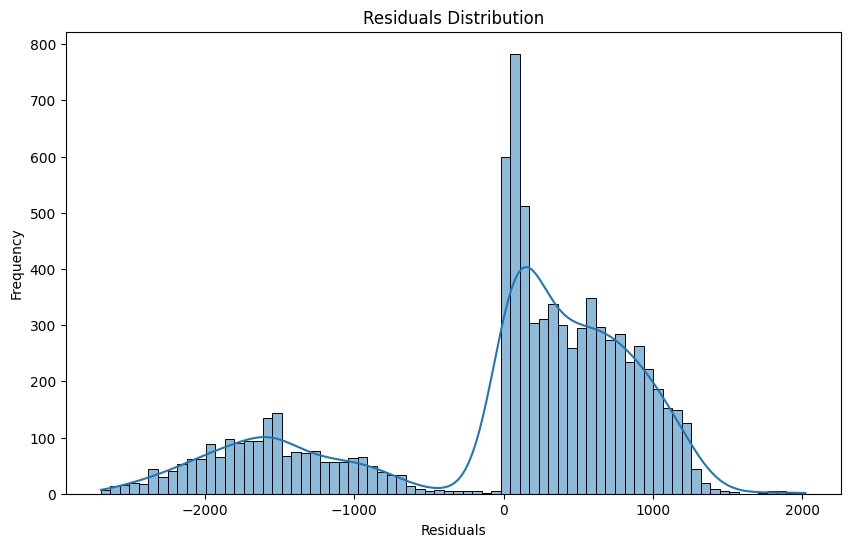

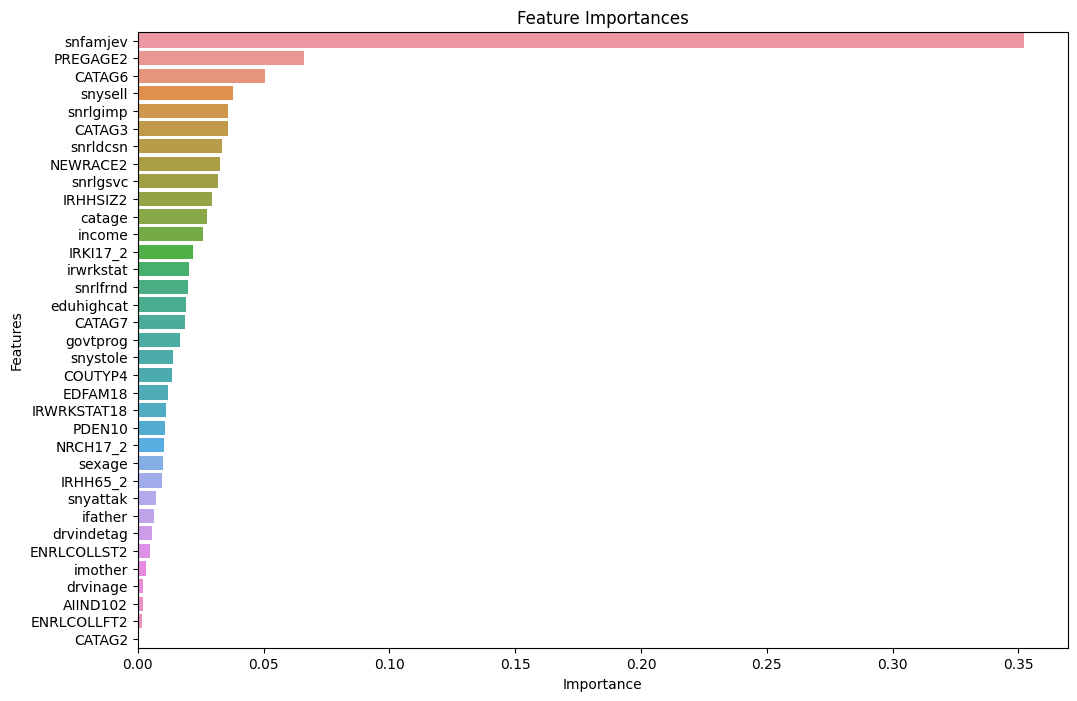

In [16]:
a = df
a_x = a[X_cols]
a_y = a['irmjfy']

# Box-Cox 변환
a_y_boxcox, _ = boxcox(a_y + 1)

# 파이프라인을 사용하여 스케일링과 모델을 결합
def train_with_each_y(Xdata, Ydata):
    # 파이프라인 정의
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # 스케일링
        ('regressor', RandomForestRegressor())  # 랜덤 포레스트
    ])

    # 하이퍼파라미터 공간 정의
    param_space = {
        'regressor__n_estimators': (50, 300),
        'regressor__max_features': ['auto', 'sqrt', 'log2'],
        'regressor__max_depth': (5, 50),
        'regressor__min_samples_split': (2, 10),
        'regressor__min_samples_leaf': (1, 4),
        'regressor__bootstrap': [True]
    }

    # 베이지안 최적화를 이용한 하이퍼파라미터 튜닝
    opt = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_space,
        n_iter=50,  # 더 많은 반복을 수행하여 최적의 파라미터 탐색
        cv=5,
        n_jobs=-1,
        verbose=0,
        scoring='r2',
        random_state=42
    )
    
    opt.fit(Xdata, Ydata)
    
    best_pipeline = opt.best_estimator_
    
    # 교차 검증
    cv_scores = cross_val_score(best_pipeline, Xdata, Ydata, cv=5, scoring='r2')
    print('Cross-validated R2 scores:', cv_scores)
    print('Mean R2 score:', np.mean(cv_scores))

    # 모델 훈련 및 평가
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
    best_pipeline.fit(X_train, y_train)
    pred_y = best_pipeline.predict(X_test)
    print(' --      RF      -- ')
    print('r2 :', r2_score(y_test, pred_y), ' mse: ', mean_squared_error(y_test, pred_y), ' mae: ', mean_absolute_error(y_test, pred_y))

    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()


    # 중요 특징 시각화
    feature_importances = best_pipeline.named_steps['regressor'].feature_importances_
    features = Xdata.columns
    importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Features', data=importance_df)
    plt.title('Feature Importances')
    plt.show()


train_with_each_y(a_x, a_y_boxcox)

C:\Users\pc\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Cross-validated R2 scores: [0.22881192 0.22290317 0.22993281 0.23379402 0.240757  ]
Mean R2 score: 0.2312397828050056


C:\Users\pc\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


 --      RF      -- 
r2 : 0.24066498087432298  mse:  0.19980323456831797  mae:  0.3492032276200309


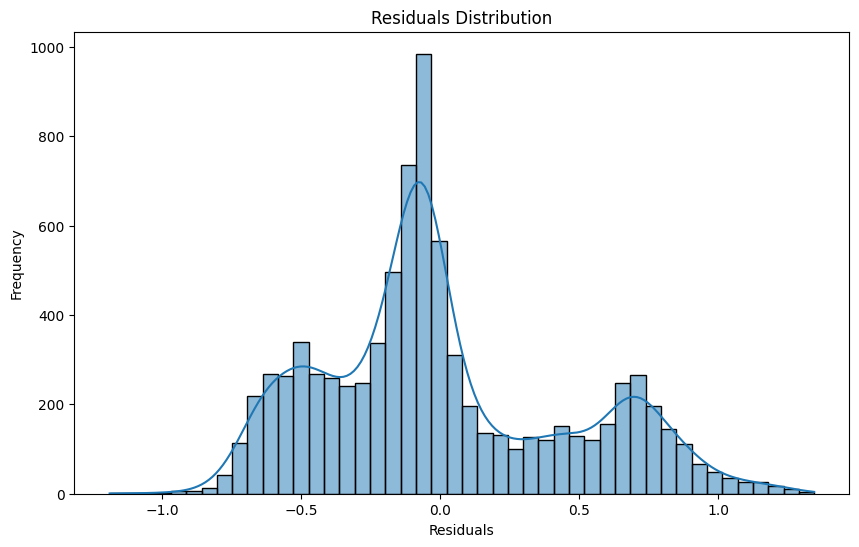

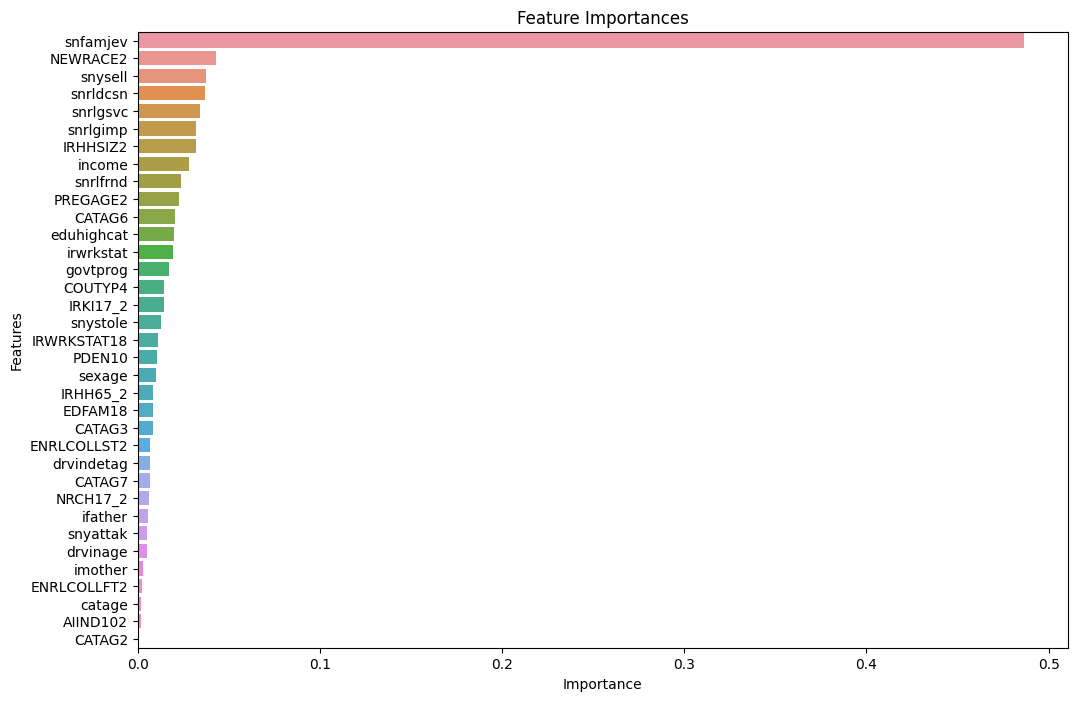

In [17]:
a = df
a_x = a[X_cols]
a_y = a['irmjfy_2']

# Box-Cox 변환
a_y_yeojohnson, _ = yeojohnson(a_y + 1)

# 파이프라인을 사용하여 스케일링과 모델을 결합
def train_with_each_y(Xdata, Ydata):
    # 파이프라인 정의
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # 스케일링
        ('regressor', RandomForestRegressor())  # 랜덤 포레스트
    ])

    # 하이퍼파라미터 공간 정의
    param_space = {
        'regressor__n_estimators': (50, 300),
        'regressor__max_features': ['auto', 'sqrt', 'log2'],
        'regressor__max_depth': (5, 50),
        'regressor__min_samples_split': (2, 10),
        'regressor__min_samples_leaf': (1, 4),
        'regressor__bootstrap': [True]
    }

    # 베이지안 최적화를 이용한 하이퍼파라미터 튜닝
    opt = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_space,
        n_iter=50,  # 더 많은 반복을 수행하여 최적의 파라미터 탐색
        cv=5,
        n_jobs=-1,
        verbose=0,
        scoring='r2',
        random_state=42
    )
    
    opt.fit(Xdata, Ydata)
    
    best_pipeline = opt.best_estimator_
    
    # 교차 검증
    cv_scores = cross_val_score(best_pipeline, Xdata, Ydata, cv=5, scoring='r2')
    print('Cross-validated R2 scores:', cv_scores)
    print('Mean R2 score:', np.mean(cv_scores))

    # 모델 훈련 및 평가
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
    best_pipeline.fit(X_train, y_train)
    pred_y = best_pipeline.predict(X_test)
    print(' --      RF      -- ')
    print('r2 :', r2_score(y_test, pred_y), ' mse: ', mean_squared_error(y_test, pred_y), ' mae: ', mean_absolute_error(y_test, pred_y))

    # 잔차 분석
    residuals = y_test - pred_y
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()


    # 중요 특징 시각화
    feature_importances = best_pipeline.named_steps['regressor'].feature_importances_
    features = Xdata.columns
    importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Features', data=importance_df)
    plt.title('Feature Importances')
    plt.show()


train_with_each_y(a_x, a_y_yeojohnson)